# [0.5] - VAEs & GANs


Colab: [exercises](https://drive.google.com/file/d/1WpSxK44Kpnuic6dC0uWwQFcMnG8J4FRr/view?usp=sharing) | [solutions](https://drive.google.com/file/d/1RG8HPjlmxyXjHUXebCgnpojNH3lLZUAI/view?usp=sharing)

ARENA 3.0 [Streamlit page](https://arena3-chapter0-fundamentals.streamlit.app/[0.4]_Backprop)

Please send any problems / bugs on the `#errata` channel in the [Slack group](https://join.slack.com/t/arena-uk/shared_invite/zt-2noug8mpy-TRYbCnc3pzj7ITNrZIjKww), and ask any questions on the dedicated channels for this chapter of material.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/paint.png" width="350">


# Introduction

Today, we're studying two important classes of generative image models: **Generative Adversarial Networks (GANs)** and **Variational Autoencoders (VAEs)**. Although these generally aren't SOTA any more (thanks in part to the rise of diffusion models), there are some deep conceptual insights which can be gleaned from studying these models (VAEs in particular) which help lay the groundwork for more advanced models.

These exercises will also hopefully bring much of this chapter full-circle:

* We'll cover transposed convolutions, which will serve as a refresher on some of the ideas behind convolutions **(day 2: CNNs & ResNets)**
* We'll be assembling NNet architectures from scratch, like in the ResNets exercises **(day 2: CNNs & ResNets)**
* We'll work with different loss functions, and think intuitively about what it means to optimize them **(day 3: Optimization & Hyperparameters)**
* We'll be working with `wandb`, and will learn how to log outputs produced by our models **(day 3: Optimization & Hyperparameters)**
* We'll have to think carefully about how gradient propagation works between different parts of our model **(day 4: Backpropagation)**

## Content & Learning Objectives


### 1️⃣ Autoencoders & VAEs

Autoencoders are a relatively simple architecture, at least compared to GANs: you learn a compressed representation of your data (mainly using linear layers and convolutions), then reconstruct it back into an image (with linear layers and transposed convolutions).

Although autoencoders can learn some interesting low-dimensional representations, they are less good for generating images because their latent spaces aren't generally meaningful. This leads to VAEs, which solve this problem by having their encoders map to a distribution over latent vectors, rather than a single latent vector. This incentivises the latent space to be more meaningful, and we can more easily generate images from sample vectors in this space.

We start with some reading material on autoencoders and transposed convolutions (which are often used in parallel with convolutions, to take a latent space and map it back into a full-size image). Then, we actually implement and train VAEs to generate MNIST images, as well as a do a bit of exploring our our autoencoders' latent spaces.


> ### Learning Objectives
>
> * Learn about the transposed convolution operation
> * Understand the basic architecture of autoencoders and VAEs
> * Learn about the reparameterization trick for VAEs
> * Implement your own autoencoder
> * Implement your own VAE, and use it to generate realistic MNIST images
> * (optional) Dive deeper into the mathematical underpinnings of VAEs, and learn about the ELBO loss function


### 2️⃣ GANs

Relative to autoencoders, GANs have a few more moving pieces in their architecture. They're best thought of as two separate networks (the generator and the discriminator) which are learning different goals simultaneously. The goal of the generator is to create images which fool the discriminator, and the goal of the discriminator is to distinguish between real and fake images. The ideal equilibrium point of training is when the generator produces perfect images and the discriminator can't tell the difference between real and fake - however, that's much simpler said than done! GANs are notoriously difficult to train, and we'll have to engage with some of these difficulties during our exercises.

By the end of these exercises, you should have built and trained your own GANs, to generate celebrity pictures. By the time you're done, you'll hopefully have produced output like this (below), and you'll have everything you need to set up a competitor to Midjourney (plus or minus a few other foundational ML papers and an investment of a few hundred million dollars).
                
<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan-last-output.png" width="1100">

> ### Learning Objectives
>
> * Understand the loss function used in GANs, and why it can be expected to result in the generator producing realistic outputs.
> * Implement the DCGAN architecture from the paper, with relatively minimal guidance.
> * Learn how to identify and fix bugs in your GAN architecture, to improve convergence properties.


### 3️⃣ Bonus - Transposed Convolutions

In this section, you'll implement the transposed convolution operation manually. This is similar to a regular convolution, but designed for upsampling rather than downsampling (i.e. producing an image from a latent vector rather producing output from an image). These are very important in many generative algorithms. Once you implement this, you'll be able to build your own GANs and VAEs from scratch, without using any pre-built layers.

*Note - the bonus section from the CNNs day is a prerequisite for these bonus exercises. If you haven't completed that section, you'll need to do so before attempting these.*

> ### Learning Objectives
>
> * Learn about & implement the transposed convolution operation.
> * Implement GANs and/or VAEs entirely from scratch.


## Setup (don't read, just run!)


In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install packages
    %pip install einops
    %pip install jaxtyping
    %pip install wandb
    %pip install torchinfo
    %pip install datasets

    # Code to make sure output widgets display
    from google.colab import output
    output.enable_custom_widget_manager()

    # Code to download the necessary files (e.g. solutions, test funcs)
    import os, sys
    if not os.path.exists("chapter0_fundamentals"):
        !wget https://github.com/callummcdougall/ARENA_3.0/archive/refs/heads/arena_pre_v4.zip
        !unzip /content/arena_pre_v4.zip 'ARENA_3.0-arena_pre_v4/chapter0_fundamentals/exercises/*'
        os.remove("/content/arena_pre_v4.zip")
        os.rename("ARENA_3.0-arena_pre_v4/chapter0_fundamentals", "chapter0_fundamentals")
        os.rmdir("ARENA_3.0-arena_pre_v4")
        sys.path.insert(0, "chapter0_fundamentals/exercises")

    # Clear output
    from IPython.display import clear_output
    clear_output()
    print("Imports & installations complete!")

else:
    raise Exception("If running from VSCode, you should copy code from the Streamlit page, not the Colab.")

In [ ]:
import os
import sys
from dataclasses import dataclass, field
from pathlib import Path
from typing import Literal

import einops
import numpy as np
import pandas as pd
import plotly.express as px
import torch as t
import torchinfo
import wandb
from datasets import load_dataset
from einops.layers.torch import Rearrange
from PIL import Image
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from tqdm import tqdm

# Get file paths to this set of exercises
exercises_dir = Path("chapter0_fundamentals/exercises")
section_dir = exercises_dir / "part5_gans_and_vaes"

import part5_gans_and_vaes.tests as tests
from part2_cnns.solutions import BatchNorm2d, Linear, ReLU, Sequential
from part2_cnns.solutions_bonus import (
    Conv2d,
    IntOrPair,
    Pair,
    conv1d_minimal,
    conv2d_minimal,
    pad1d,
    pad2d,
)
from part2_cnns.utils import print_param_count
from plotly_utils import imshow

device = t.device("cuda" if t.cuda.is_available() else "cpu")

<details>
<summary>Help - I get a NumPy-related error</summary>

This is an annoying colab-related issue which I haven't been able to find a satisfying fix for. If you restart runtime (but don't delete runtime), and run just the imports cell above again (but not the `%pip install` cell), the problem should go away.
</details>


# 1️⃣ Autoencoders & VAEs

> ### Learning Objectives
>
> * Learn about the transposed convolution operation
> * Understand the basic architecture of autoencoders and VAEs
> * Learn about the reparameterization trick for VAEs
> * Implement your own autoencoder
> * Implement your own VAE, and use it to generate realistic MNIST images
> * (optional) Dive deeper into the mathematical underpinnings of VAEs, and learn about the ELBO loss function

## Reading

**Note** - before you start the reading, you might want to run the first block of code in the "Loading data" section, because it can take a few minutes to run.

* [Understanding VAEs (Towards Data Science)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
    * A clear and accessible explanation of autoencoders and VAEs.
    * You can stop at "Mathematical details of VAEs"; we'll (optionally) cover this in more detail later.
* [Six (and a half) intuitions for KL divergence](https://www.lesswrong.com/posts/no5jDTut5Byjqb4j5/six-and-a-half-intuitions-for-kl-divergence)
    * Optional reading.
    * KL divergence is an important concept in VAEs (and will continue to be a useful concept for the rest of this course).
* [From Autoencoder to Beta-VAE](https://lilianweng.github.io/posts/2018-08-12-vae/)
    * Optional reading.
    * This is a more in-depth look at VAEs, the maths behind them, and different architecture variants.
* [Transposed Convolutions explained with… MS Excel!](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8) (optional)
    * Optional reading.
    * The first part (up to the highlighted comment) is most valuable, since understanding transposed convolutions at a high level is more important than understanding the exact low-level operations that go into them (that's what the bonus is for!).
    * [These visualisations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) may also help.

## Loading data

In these exercises, we'll be using either the Celeb-A dataset or the MNIST dataset. For convenience, we'll include a few functions here to load that data in.

You should already be familiar with MNIST. You can read about the Celeb-A dataset [here](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) - essentially it's a large-scale face attributes dataset with more than 200k celebrity images, but we'll only be taking the images from this dataset rather the classifications. Run the code below to download the data from HuggingFace, and save it in your filesystem as images.

The code should take 2-10 minutes to run, but feel free to move on if it's taking longer (you'll mostly be using MNIST in this section, and only using Celeb-A when you move on to GANs).

In [ ]:
celeb_data_dir = section_dir / "data/celeba"
celeb_image_dir = celeb_data_dir / "img_align_celeba"

os.makedirs(celeb_image_dir, exist_ok=True)

if len(list(celeb_image_dir.glob("*.jpg"))) > 0:
    print("Dataset already loaded.")
else:
    dataset = load_dataset("nielsr/CelebA-faces")
    print("Dataset loaded.")

    for idx, item in tqdm(enumerate(dataset["train"]), total=len(dataset["train"]), desc="Saving individual images..."):
        # The image is already a JpegImageFile, so we can directly save it
        item["image"].save(celeb_image_dir / f"{idx:06}.jpg")

    print("All images have been saved.")

<details>
<summary>Note on why we double-nest our saving paths, i.e. <code>celeba/img_align_celeba</code></summary>

In the code above, each image is saved in the format `'data/celeba/img_align_celeba/000001.jpg'`, etc. The reason for this double nesting (rather than e.g. `data/celeba/000001.jpg`) is that the child folders represent the image classes. If we were training a classifier, we'd have multiple folders within `data/celeba`, with each one being a different class. In this dataset, we only have one class (real celeb images), so we only need one child folder.

</details>

Now, here's some code to load in either the Celeb-A or MNIST data. It also applies transformations to the data, to get it into the right input format for us.

The function below allows you to load in either the Celeb-A or MNIST data.

In [ ]:
def get_dataset(dataset: Literal["MNIST", "CELEB"], train: bool = True) -> Dataset:
    assert dataset in ["MNIST", "CELEB"]

    if dataset == "CELEB":
        image_size = 64
        assert train, "CelebA dataset only has a training set"
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])
        trainset = datasets.ImageFolder(
            root = exercises_dir / "part5_gans_and_vaes/data/celeba",
            transform = transform
        )

    elif dataset == "MNIST":
        img_size = 28
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        trainset = datasets.MNIST(
            root = exercises_dir / "part5_gans_and_vaes/data",
            transform = transform,
            download = True,
        )

    return trainset

We've also given you some code for visualising your data. You should run this code to make sure your data is correctly loaded in.


In [ ]:
def display_data(x: t.Tensor, nrows: int, title: str):
    '''Displays a batch of data, using plotly.'''
    # Reshape into the right shape for plotting (make it 2D if image is monochrome)
    y = einops.rearrange(x, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=nrows).squeeze()
    # Normalize, in the 0-1 range
    y = (y - y.min()) / (y.max() - y.min())
    # Display data
    imshow(
        y, binary_string=(y.ndim==2), height=50*(nrows+5),
        title=title + f"<br>single input shape = {x[0].shape}"
    )

trainset_mnist = get_dataset("MNIST")
trainset_celeb = get_dataset("CELEB")

In [ ]:
# Display MNIST
x = next(iter(DataLoader(trainset_mnist, batch_size=64)))[0]
display_data(x, nrows=8, title="MNIST data")

# Display CelebA
x = next(iter(DataLoader(trainset_celeb, batch_size=64)))[0]
display_data(x, nrows=8, title="CalebA data")

### Holdout data

Lastly, we'll also get some **holdout data** that we can use during training. The tensor below has shape `(10, 1, 28, 28)`, and contains a single image from each of the 10 MNIST classes. We do this because we want to monitor our autoencoder's reconstructions for each different image type while it trains. We might find that some images are reconstructed better than others!

In [ ]:
testset = get_dataset("MNIST", train=False)
HOLDOUT_DATA = dict()
for data, target in DataLoader(testset, batch_size=1):
    if target.item() not in HOLDOUT_DATA:
        HOLDOUT_DATA[target.item()] = data.squeeze()
        if len(HOLDOUT_DATA) == 10: break
HOLDOUT_DATA = t.stack([HOLDOUT_DATA[i] for i in range(10)]).to(dtype=t.float, device=device).unsqueeze(1)

display_data(HOLDOUT_DATA, nrows=1, title="MNIST holdout data")

You might be wondering why we do this, rather than just e.g. generating some random noise and seeing what the decoder's reconstruction is. The answer is that **our autoencoder's latent space might not be meaningful**. In other words, it's unclear exactly how to sample from it to get output which will look like an MNIST image. We'll return to this idea when we study VAEs later in these exercises.

*For the rest of this section (not including the bonus), we'll assume we're working with the MNIST dataset rather than Celeb-A.*

## Transposed Convolutions

**What are transposed convolutions, and why should we care about them?** One high-level intuition goes something like this: most of the generator's architecture is basically the discriminator architecture in reverse. We need something that performs the reverse of a convolution - not literally the inverse operation, but something reverse in spirit, which uses a kernel of weights to project up to some array of larger size.

**Importantly, a transposed convolution isn't literally the inverse of a convolution**. A lot of confusion can come from misunderstanding this!

You can describe the difference between convolutions and transposed convolutions as follows:

* In convolutions, you slide the kernel around inside the input. At each position of the kernel, you take a sumproduct between the kernel and that section of the input to calculate a single element in the output.
* In transposed convolutions, you slide the kernel around what will eventually be your output, and at each position you add some multiple of the kernel to your output.

Below is an illustration of both for comparison, in the 1D case (where $*$ stands for the 1D convolution operator, and $*^T$ stands for the transposed convolution operator). Note the difference in size between the output in both cases. With standard convolutions, our output is smaller than our input, because we're having to fit the kernel inside the input in order to produce the output. But in our transposed convolutions, the output is actually larger than the input, because we're fitting the kernel inside the output.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/convtranspose-1.png" width="700">

We won't actually have you implement the transposed convolution operation in these exercises; instead we've pushed it to the bonus section. Instead, you can use the `conv_transpose2d` function from the solutions. We also won't have you implement the transposed convolution module, since this is just the same exercises as you did for convolutions earlier in this chapter. You can take the code below and use it to define your transposed convolutional layers. However, make sure you understand the high-level details of this module: what the arguments are, what the input & output shapes are, etc.

## Autoencoders

We'll start by looking at **Autoencoders**, which are much conceptually simpler than VAEs. These are simply systems which learn a compressed representation of the input, and then reconstruct it. There are two parts to this:

* The **encoder** learns to compress the output into a latent space which is lower-dimensional than the original image.
* The **decoder** learns to uncompress the encoder's output back into a faithful representation of the original image.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/ae-diagram-l.png" width="700">
                
Our loss function is simply some metric of the distance between the input and the reconstructed input, e.g. the $l_2$ loss.

You'll start by writing your own autoencoder. We've given some guidance on architecture below, although in general because we're working with a fairly simple dataset (MNIST) and a fairly robust architecture (at least compared to GANs in the next section!), you model is still likely to work well even if it deviates slightly from the specification we'll give below.

### Exercise - implement autoencoder

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 15-30 minutes on this exercise.
```

*Note - for the rest of this section (not including the bonus), we'll assume we're working with the MNIST dataset rather than Celeb-A.*

Your encoder should consist of two convolutional blocks (i.e. convolution plus ReLU), followed by two fully connected linear layers with a ReLU in between them. Both convolutions will have kernel size 4, stride 2, padding 1 (recall this halves the size of the image). We'll have 16 and 32 output channels respectively.

The decoder will be the exact mirror image of the encoder (with convolutions replaced by transposed convolutions).

The only free parameters in your implementation will be `latent_dim_size` and `hidden_dim_size`. The former determines the size of the latent space (otherwise called the bottleneck dimension) between the encoder and decoder, and the latter determines the size of the final linear layer we insert just before the end / just after the start of the encoder / decoder's architecture respectively.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/ae-help-10.png" width="1100">

A few extra notes:

* You'll need to reshape between the convolutional blocks and linear layers. For this, you might find the `einops` library helpful - they have a function `einops.layers.torch.Rearrange` (imported for you as `Rearrange`) which works like the standard einops function, except that it takes a string and returns a module which performs the corresponding rearrangement. Just like any other module, it can be used inside things like `Sequential` (this way, the logic inside the `forward` method can be very simple!).

```python
>>> x = t.randn(100, 3, 4, 5)
>>> x.shape
torch.Size([100, 3, 4, 5])

>>> module = Rearrange("b c h w -> b (c h w)")
>>> module(x).shape
torch.Size([100, 60])
```

* Note that we don't include a ReLU in the very last layer of the decoder or generator, we only include them ***between successive convolutions or linear layers*** - can you see why it wouldn't make sense to put ReLUs at the end?
* The convolutions don't have biases, although we have included biases in the linear layers (this will be important if you want your parameter count to match the solution, but not really that important for good performance).

Now, implement your autoencoder below:

In [ ]:
from jaxtyping import Float

class Autoencoder(nn.Module):

    def __init__(self, latent_dim_size: int, hidden_dim_size: int):
        super().__init__()
        self.latent_dim_size = latent_dim_size
        self.hidden_dim_size = hidden_dim_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.ReLU(),
            Rearrange("b c h w -> b (c h w)"),
            nn.Linear(32*7*7, hidden_dim_size),
            nn.ReLU(),
            nn.Linear(hidden_dim_size, latent_dim_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim_size, hidden_dim_size),
            nn.ReLU(),
            nn.Linear(hidden_dim_size, 32*7*7),
            Rearrange("b (c h w) -> b c h w", c=32, h=7, w=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1, bias=False),
        )

    def forward(self, x: Float[t.Tensor, "b c h w"]) -> Float[t.Tensor, "b c h w"]:
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def extra_repr(self) -> str:
        return f"Autoencoder with latent_dim_size: {self.latent_dim_size}, hidden_dim_size: {self.hidden_dim_size}"

<details>
<summary>Solution</summary>

```python
class Autoencoder(nn.Module):

    def __init__(self, latent_dim_size: int, hidden_dim_size: int):
        super().__init__()
        self.latent_dim_size = latent_dim_size
        self.hidden_dim_size = hidden_dim_size
        self.encoder = Sequential(
            Conv2d(1, 16, 4, stride=2, padding=1),
            ReLU(),
            Conv2d(16, 32, 4, stride=2, padding=1),
            ReLU(),
            Rearrange("b c h w -> b (c h w)"),
            Linear(7 * 7 * 32, hidden_dim_size),
            ReLU(),
            Linear(hidden_dim_size, latent_dim_size)
        )
        self.decoder = Sequential(
            Linear(latent_dim_size, hidden_dim_size),
            ReLU(),
            Linear(hidden_dim_size, 7 * 7 * 32),
            ReLU(),
            Rearrange("b (c h w) -> b c w h", c=32, h=7, w=7),
            solutions.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            ReLU(),
            solutions.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        z = self.encoder(x)
        x_prime = self.decoder(z)
        return x_prime
```
</details>

You can test your answer by comparing the architecture to the solution directly. As this course goes on, we won't always include test functions as the exercises get a bit more open-ended and solutions to them are likely to vary more; it's also good practice to find ways to test your answers when you don't have access to black-box tests that you can trust!

In [ ]:
import part5_gans_and_vaes.solutions as solutions

soln_Autoencoder = solutions.Autoencoder(latent_dim_size=5, hidden_dim_size=128)
my_Autoencoder = Autoencoder(latent_dim_size=5, hidden_dim_size=128)

print_param_count(my_Autoencoder, soln_Autoencoder)

## Training your Autoencoder

Once you've got the architecture right, you should write a training loop which works with [MSE loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) between the original and reconstructed data. The standard Adam optimiser with default parameters should suffice.

### Logging images to `wandb`

Weights and biases provides a nice feature allowing you to log images! This requires you to use the function `wandb.Image`. The first argument is `data_or_path`, which can be any of the following:

* A numpy array in shape `(height, width)` or `(height, width, 1)` -> interpreted as monochrome image
* A numpy array in shape `(height, width, 3)` -> interpreted as RGB image
* A PIL image (can be RGB or monochrome)

When it comes to logging, you can log a list of images rather than a single image. Example code, and the output it produces from my GAN (you'll create output like this in the next section!):

```python
# arr is a numpy array of shape (8, 28, 28, 3), i.e. it's an array of 8 RGB images
images = [wandb.Image(a) for a in arr]
wandb.log({"images": images}, step=self.step)
```

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/gan_output_2.png" width="750">

### Exercise - write autoencoder training loop

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 20-35 minutes on this exercise.
```

You should now implement your training loop below. We've filled in the `__init__` method for you, as well as the `train` method which determines the core structure of the training loop. We've also given you a dataclass to hold arguments.

You should fill in the following methods:

- `training_step`, which performs a single training step by minimizing the reconstruction loss between the image and target (you might find `nn.MSELoss` suitable for this).
- `evaluate`, which evaluates the model on the holdout data. If `args.use_wandb=True` then this should log to wandb, but if `False` then this should do something different, e.g. `display_data(holdout_data_output)` to display the output inline.

**Recommendation** - don't use wandb until you've ironed out the bugs in your code, and loss seems to be going down based on the in-notebook logging.

In [ ]:
@dataclass
class AutoencoderArgs():
    # architecture
    latent_dim_size: int = 5
    hidden_dim_size: int = 128

    # data / training
    dataset: Literal["MNIST", "CELEB"] = "MNIST"
    batch_size: int = 512
    epochs: int = 10
    lr: float = 1e-3
    betas: tuple[float, float] = (0.5, 0.999)

    # logging
    use_wandb: bool = True
    wandb_project: str | None = 'day5-ae-mnist'
    wandb_name: str | None = None


class AutoencoderTrainer:
    def __init__(self, args: AutoencoderArgs):
        self.args = args
        self.trainset = get_dataset(args.dataset)
        self.trainloader = DataLoader(self.trainset, batch_size=args.batch_size, shuffle=True, num_workers=8)
        self.model = Autoencoder(
            latent_dim_size = args.latent_dim_size,
            hidden_dim_size = args.hidden_dim_size,
        ).to(device)
        self.optimizer = t.optim.Adam(self.model.parameters(), lr=args.lr, betas=args.betas)

    def training_step(self, img: Float[t.Tensor, "b c h w"]) -> Float[t.Tensor, "1"]:
        '''
        Performs a training step on the batch of images in `img`. Returns the loss.
        '''
        img_hat = self.model(img)
        loss = nn.functional.mse_loss(img, img_hat, reduction="mean")
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    @t.inference_mode()
    def evaluate(self) -> None:
        '''
        Evaluates model on holdout data, logs to weights & biases.
        '''
        img_hat = self.model(HOLDOUT_DATA)
        loss = nn.functional.mse_loss(HOLDOUT_DATA, img_hat, reduction="mean")
        if self.args.use_wandb:
            wandb.log({
                "images": [wandb.Image(a) for a in img_hat],
                "val_loss": loss.item()
            }, step=self.step)
        else:
            print(f"Eval loss: {loss.item():.2f}")
            display_data(img_hat, nrows=1, title=f"Reconstruction of holdout data after step: {self.step}")

    def train(self) -> None:
        '''
        Performs a full training run, logging to wandb.
        '''
        self.step = 0
        if self.args.use_wandb:
            wandb.init(project=self.args.wandb_project, name=self.args.wandb_name)
            wandb.watch(self.model)

        for epoch in range(self.args.epochs):
            progress_bar = tqdm(self.trainloader, total=int(len(self.trainloader)))

            for (img, label) in progress_bar: # remember that label is not used
                img = img.to(device)
                loss = self.training_step(img)
                if self.args.use_wandb:
                    wandb.log(dict(loss=loss), step=self.step)

                # Update progress bar
                self.step += img.shape[0]
                progress_bar.set_description(f"{epoch=}, {loss=:.4f}, examples_seen={self.step}")

            # Evaluate model on the same holdout data
            self.evaluate()

        if self.args.use_wandb:
            wandb.finish()

In [ ]:
# If you find yourself disconnecting from runtime when you run the training code,
# then visit `https://wandb.ai/authorize` and get a <LOGIN-KEY> to use here:

wandb.login()

# If this still doesn't work for you (i.e. you're getting disconnected), then we
# recommend either using VSCode, or just setting wandb=False and displaying your
# output inline.

In [ ]:
args = AutoencoderArgs()
trainer = AutoencoderTrainer(args)
trainer.train()

**Comparison: Reconstruction of holdout data after 60k and 600k steps (1 and 10 epochs respectively)**
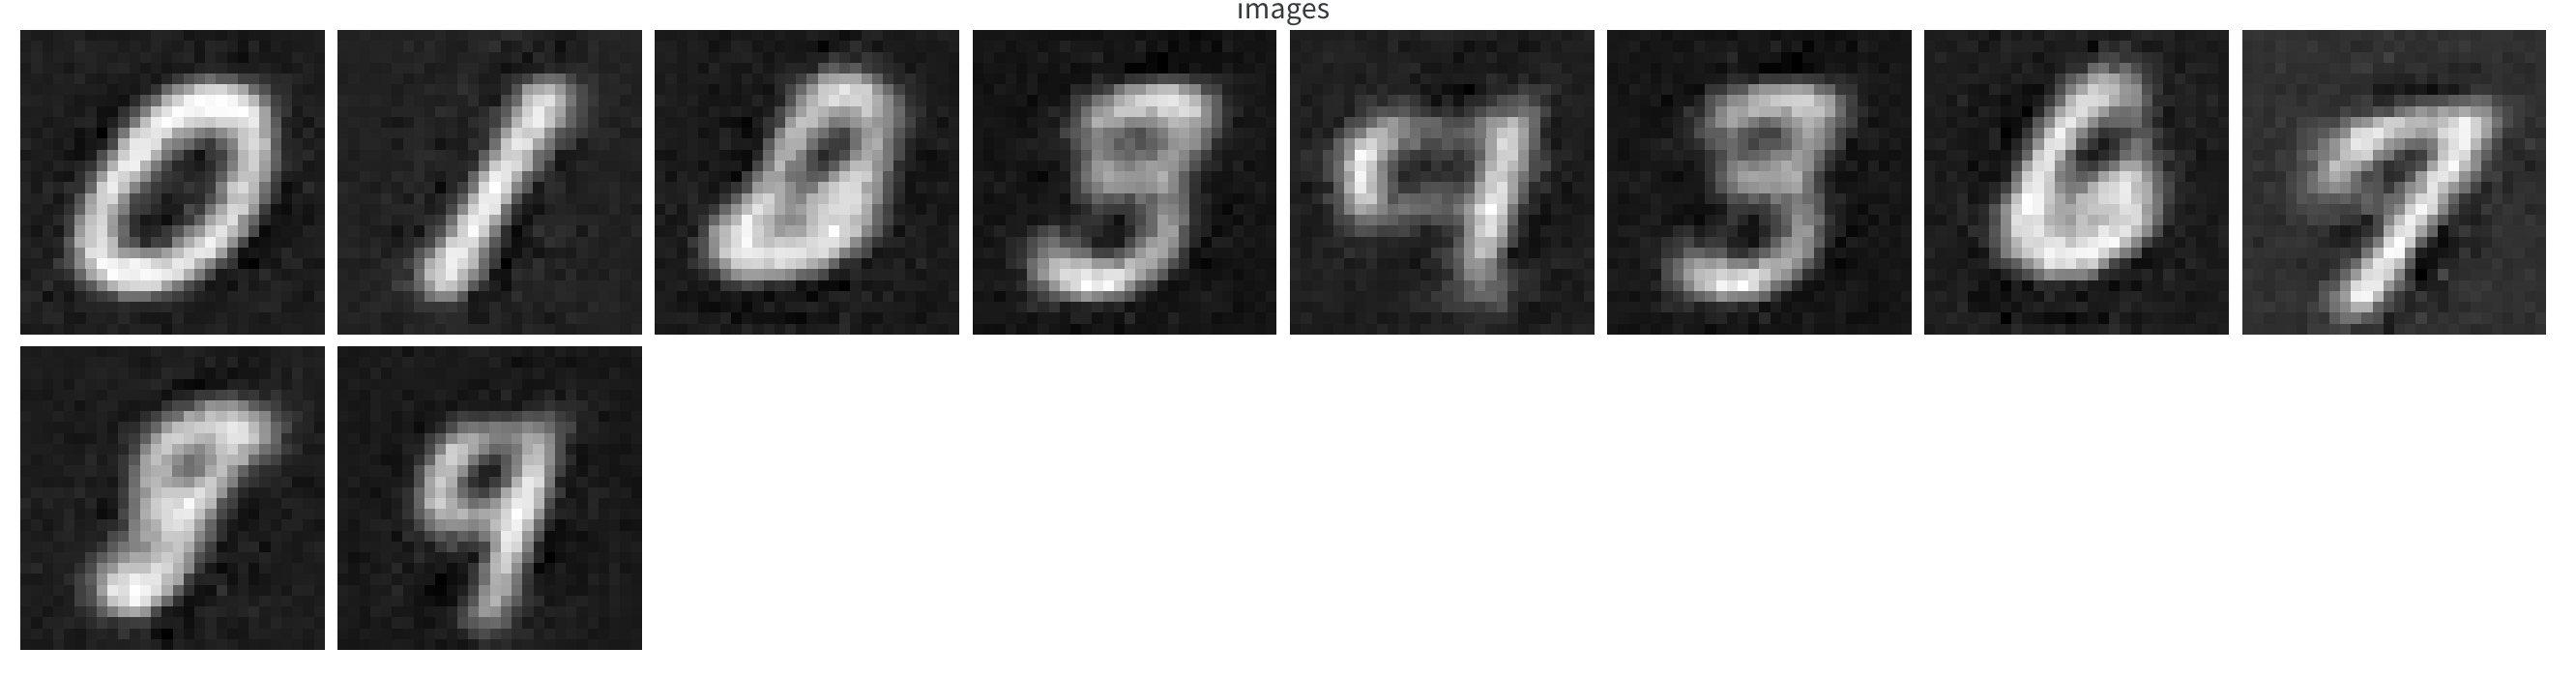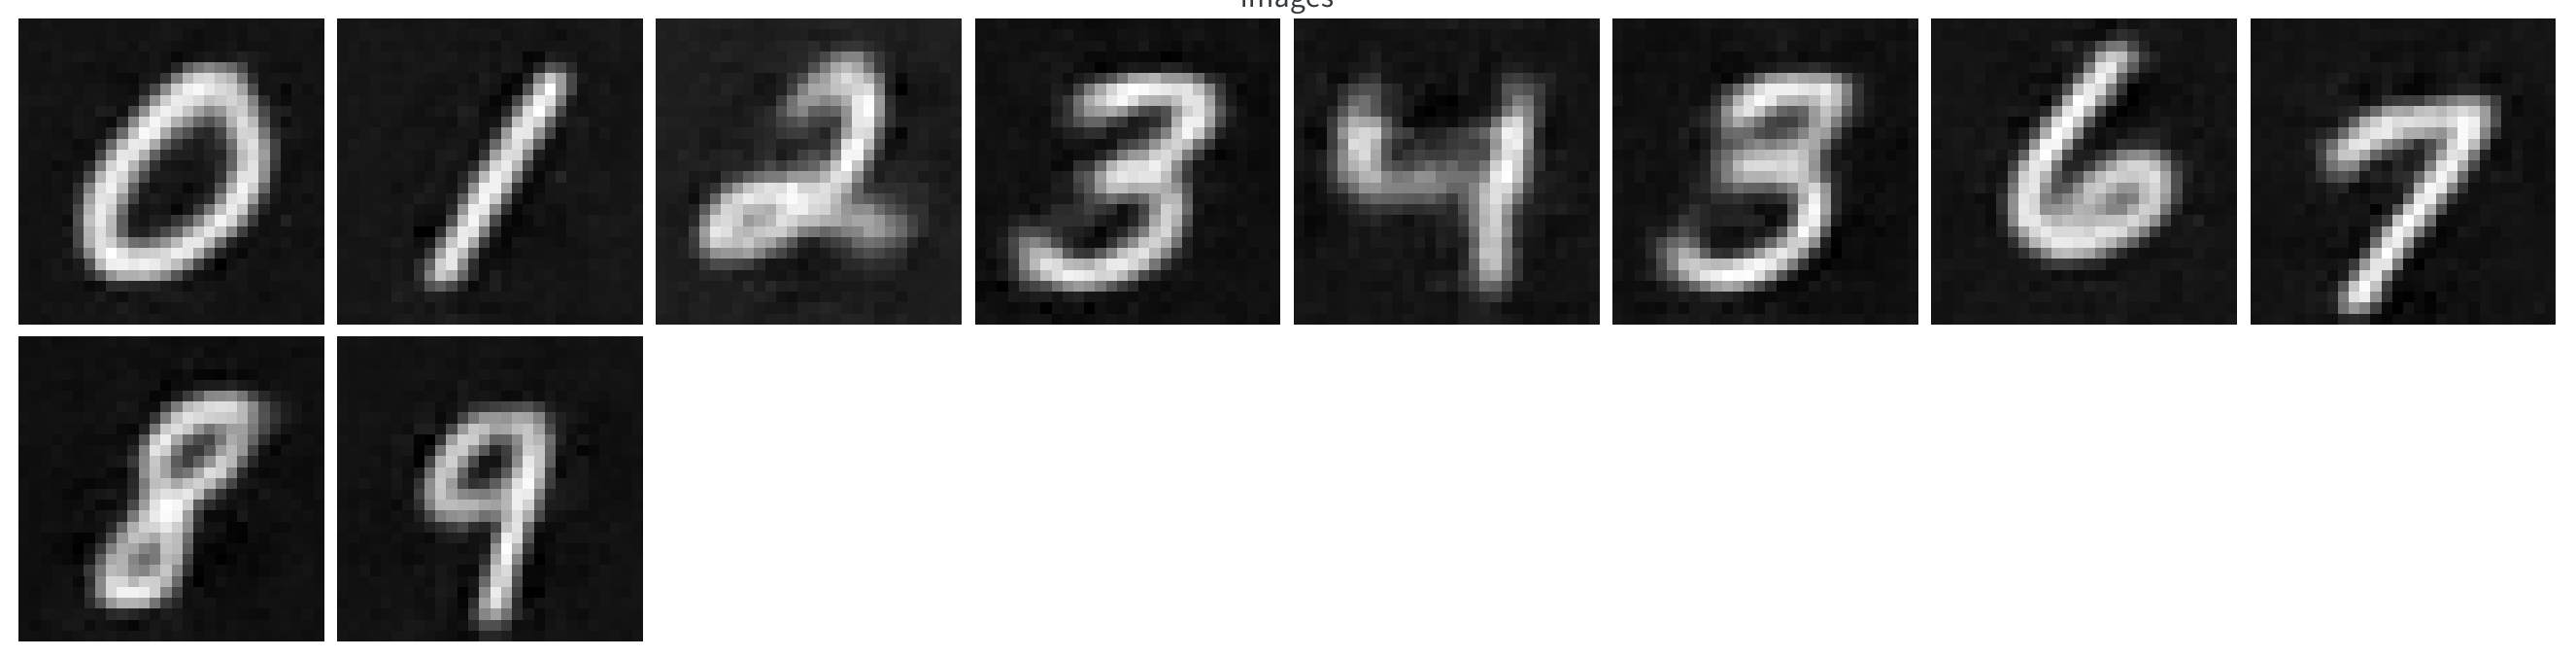

**Training and validation loss**
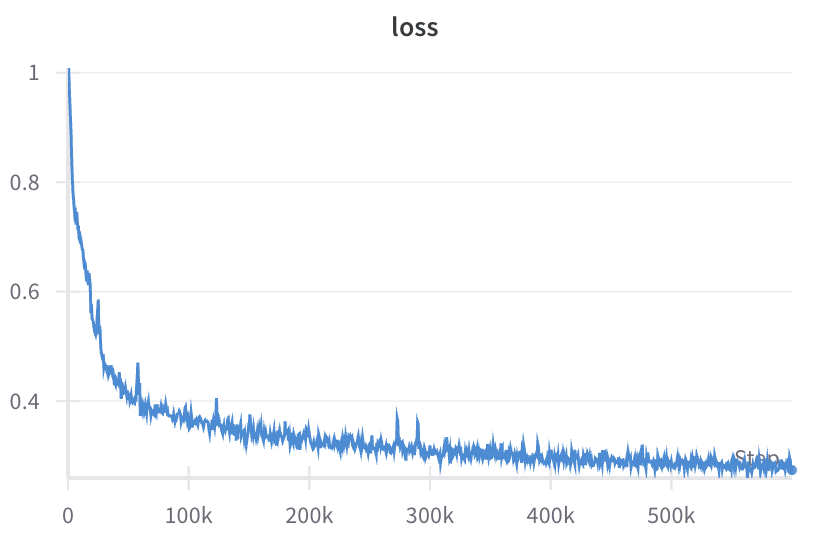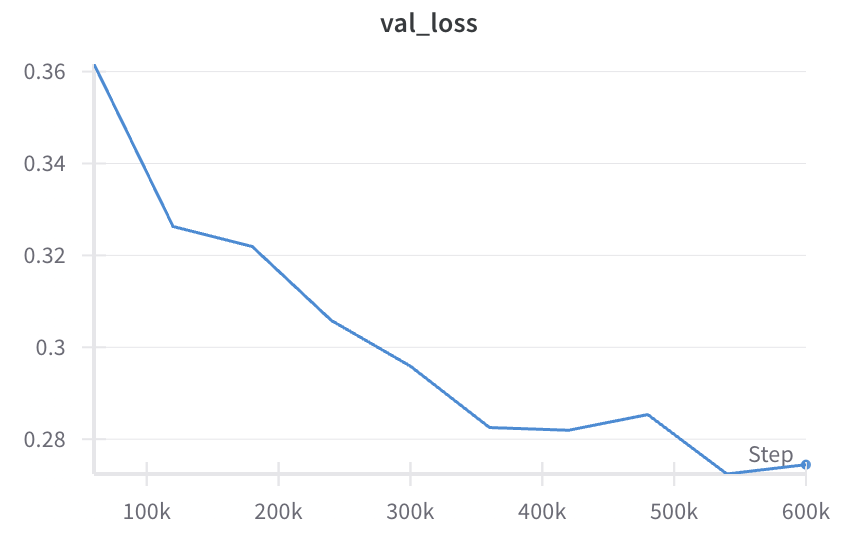

<details>
<summary>Solution</summary>

```python
def training_step(self, img: t.Tensor) -> t.Tensor:
    '''
    Performs a training step on the batch of images in `img`. Returns the loss.
    '''
    img_reconstructed = self.model(img)
    loss = nn.MSELoss()(img, img_reconstructed)
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()
    return loss

@t.inference_mode()
def evaluate(self) -> None:
    '''
    Evaluates model on holdout data, logs to weights & biases.
    '''
    output = self.model(HOLDOUT_DATA)
    if self.args.use_wandb:
        wandb.log({"images": [wandb.Image(arr) for arr in output.cpu().numpy()]}, step=self.step)
    else:
        display_data(t.concat([HOLDOUT_DATA, output]), nrows=2, title="AE reconstructions")```

</details>

After 10 epochs, you should be able to get output of the following quailty:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/autoencoder_2.png" width="700">

Note how the reconstructions it's mixing up features for some of the numbers - for instance, the 5 seems to have been partly reproduced as a 9. But overall, it seems pretty accurate!

## Latent space of an autoencoder

We'll now return to the issue we mentioned briefly earlier - how to generate output? We might want to generate output by just producing random noise and passing it through our decoder, but this raises a question - how should we interpret the latent space between our encoder and decoder?

We can try and plot the outputs produced by the decoder over a range. The code below does this for the model in the solutions (you might have to make some small adjustments depending on exactly how you've implemented your autoencoder).

In [ ]:
@t.inference_mode()
def visualise_output(
    model: Autoencoder,
    n_points: int = 11,
    interpolation_range: tuple[float, float] = (-3, 3),
) -> None:
    '''
    Visualizes the output of the decoder, along the first two latent dims.
    '''
    # Constructing latent dim data by making two of the dimensions vary indep in the interpolation range
    grid_latent = t.zeros(n_points**2, model.latent_dim_size).to(device)
    x = t.linspace(*interpolation_range, n_points).to(device)
    grid_latent[:, 0] = einops.repeat(x, "dim1 -> (dim1 dim2)", dim2=n_points)
    grid_latent[:, 1] = einops.repeat(x, "dim2 -> (dim1 dim2)", dim1=n_points)

    # Pass through decoder
    output = model.decoder(grid_latent).cpu().numpy()

    # Normalize & truncate, then unflatten back into a grid shape
    output_truncated = np.clip((output * 0.3081) + 0.1307, 0, 1)
    output_single_image = einops.rearrange(
        output_truncated, "(dim1 dim2) 1 height width -> (dim1 height) (dim2 width)", dim1=n_points
    )

    # Display the results
    tickargs = dict(
        tickmode="array",
        tickvals=list(range(14, 14 + 28 * n_points, 28)),
        ticktext=[f"{i:.2f}" for i in x],
    )
    px.imshow(
        output_single_image,
        color_continuous_scale="greys_r",
        title="Decoder output from varying first principal components of latent space",
    ).update_layout(
        xaxis=dict(title_text="dim1", **tickargs),
        yaxis=dict(title_text="dim2", **tickargs),
    ).show()


visualise_output(trainer.model)

(Note, we normalize with `(0.3081, 0.1307)` because this is the mean and standard deviation of the MNIST dataset - see discussion [here](https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457).)

This generates images from a vector in the latent space which is zero in all directions, except for the first two [principal directions](https://www.sartorius.com/en/knowledge/science-snippets/what-is-principal-component-analysis-pca-and-how-it-is-used-507186#:~:text=Principal%20component%20analysis%2C%20or%20PCA,more%20easily%20visualized%20and%20analyzed.).

This is ... pretty underwhelming actually. Although some of these shapes seem legible at the perimeters, a lot of the space doesn't look like any recognisable number (e.g. the middle values are pretty close to black).

Why is this? Well unfortunately, the model has no reason to treat the latent space in any meaningful way. It might be the case that almost all the images are embedded into a particular subspace of the latent space, and so the encoder only gets trained on inputs in this subspace. To further illustrate this, the code below feeds MNIST data into your encoder, and plots the resulting latent vectors (projected along the first two latent dimensions).

In [ ]:
@t.inference_mode()
def visualise_input(
    model: Autoencoder,
    dataset: Dataset,
) -> None:
    '''
    Visualises (in the form of a scatter plot) the input data in the latent space, along the first two dims.
    '''
    # First get the model images' latent vectors, along first 2 dims
    imgs = t.stack([batch for batch, label in dataset]).to(device)
    latent_vectors = model.encoder(imgs)
    if latent_vectors.ndim == 3: latent_vectors = latent_vectors[0] # useful for VAEs later
    latent_vectors = latent_vectors[:, :2].cpu().numpy()
    labels = [str(label) for img, label in dataset]

    # Make a dataframe for scatter (px.scatter is more convenient to use when supplied with a dataframe)
    df = pd.DataFrame({"dim1": latent_vectors[:, 0], "dim2": latent_vectors[:, 1], "label": labels})
    df = df.sort_values(by="label")
    fig = px.scatter(df, x="dim1", y="dim2", color="label")
    fig.update_layout(height=700, width=700, title="Scatter plot of latent space dims", legend_title="Digit")
    data_range = df["dim1"].max() - df["dim1"].min()

    # Add images to the scatter plot (optional)
    output_on_data_to_plot = model.encoder(HOLDOUT_DATA.to(device))[:, :2].cpu()
    if output_on_data_to_plot.ndim == 3: output_on_data_to_plot = output_on_data_to_plot[0] # useful for VAEs; see later
    data_translated = (HOLDOUT_DATA.cpu().numpy() * 0.3081) + 0.1307
    data_translated = (255 * data_translated).astype(np.uint8).squeeze()
    for i in range(10):
        x, y = output_on_data_to_plot[i]
        fig.add_layout_image(
            source=Image.fromarray(data_translated[i]).convert("L"),
            xref="x", yref="y",
            x=x, y=y,
            xanchor="right", yanchor="top",
            sizex=data_range/15, sizey=data_range/15,
        )
    fig.show()


small_dataset = Subset(get_dataset("MNIST"), indices=range(0, 5000))
visualise_input(trainer.model, small_dataset)

Note that there are some very high-density spots, and other much lower-density spots. So it stands to reason that we shouldn't expect the decoder to be able to produce good output for all points in the latent space (especially when we're using a 5-dimensional latent space rather than just 2-dimensional as visualised below - we can imagine that 5D latent space would have significantly more "dead space").

To emphasise, we're not looking for a crisp separation of digits here. We're only plotting 2 of 5 dimensions, it would be a coincidence if they were cleanly separated. We're looking for efficient use of the space, because this is likely to lead to an effective generator when taken out of the context of the discriminator. We don't really see that here.

## Variational Autoencoders

Variational autoencoders try and solve the problem posed by autoencoders: how to actually make the latent space meaningful, such that you can generate output by feeding a $N(0, 1)$ random vector into your model's decoder?

The key perspective shift is this: **rather than mapping the input into a fixed vector, we map it into a distribution**. The way we learn a distribution is very similar to the way we learn our fixed inputs for the autoencoder, i.e. we have a bunch of linear or convolutional layers, our input is the original image, and our output is the tuple of parameters $(\mu(\boldsymbol{x}), \Sigma(\boldsymbol{x}))$ (as a trivial example, our VAE learning a distribution $\mu(\boldsymbol{x})=z(\boldsymbol{x})$, $\Sigma(\boldsymbol{x})=0$ is equivalent to our autoencoder learning the function $z(\boldsymbol{x})$ as its encoder).

From this [TowardsDataScience](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) article:

> Due to overfitting, the latent space of an autoencoder can be extremely irregular (close points in latent space can give very *different* decoded data, some point of the latent space can give *meaningless* content once decoded) and, so, we can’t really define a *generative* process that simply consists to sample a point from the *latent space* and make it go through the decoder to get new data. *Variational autoencoders* (VAEs) are autoencoders that tackle the problem of the latent space irregularity by making the encoder return a *distribution over the latent space* instead of a single point and by adding in the loss function a *regularisation* term over that returned distribution in order to ensure a better *organisation* of the latent space.

Or, in fewer words:

> **A variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.**

At first, this idea of mapping to a distribution sounds like a crazy hack - why on earth does it work? This diagram should help convey some of the intuitions:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/vae-scatter.png" width="800">

With our encoder, there was nothing incentivising us to make full and meaningful use of the latent space. It's hypothetically possible that our network was mapping all the inputs to some very small subspace and reconstructing them with perfect fidelity. This wouldn't have required numbers with different features to be far apart from each other in the latent space, because even if they are close together no information is lost. See the first image above.

But with our variational autoencoder, each MNIST image produces a **sample** from the latent space, with a certain mean and variance. This means that, when two numbers look very different, their latent vectors are forced apart - if the means were close together then the decoder wouldn't be able to reconstruct them.

Another nice property of using random latent vectors is that the entire latent space will be meaningful. For instance, with autoencoders there is no reason why we should expect the linear interpolation between two points in the latent space to have meaningful decodings. The decoder output *will* change continuously as we continuously vary the latent vector, but that's about all we can say about it. However, if we use a variational autoencoder, we don't have this problem. The output of a linear interpolation between the cluster of $2$s and cluster of $7$s will be ***"a symbol which pattern-matches to the family of MNIST digits, but has equal probability to be interpreted as a $2$ or a $7$"***, and this is indeed what we find.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/vae-scatter-2.png" width="700">

### Reparameterisation trick

One question that might have occurred to you - how can we perform backward passes through our network? We know how to differentiate with respect to the inputs to a function, but how can we differentiate wrt the parameters of a probability distribution from which we sample our vector? The solution is to convert our random sampling into a function, by introducing an extra parameter $\epsilon$. We sample $\epsilon$ from the standard normal distribution, and then express $\boldsymbol{z}$ as a deterministic function of $\mu$, $\sigma$ and $\epsilon$:

$$
z = \mu + \sigma \odot \epsilon
$$

where $\odot$ is a notation meaning pointwise product, i.e. $z_i = \mu_i + \sigma_i \epsilon_i$. Intuitively, we can think of this as follows: when there is randomness in the process that generates the output, there is also randomness in the derivative of the output wrt the input, so **we can get a value for the derivative by sampling from this random distribution**. If we average over enough samples, this will give us a valid gradient for training.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/vae-reparam-l.png" width="800">

Note that if we have $\sigma_\theta(\boldsymbol{x})=0$ for all $\boldsymbol{x}$, the VAE reduces to an autoencoder (since the latent vector $z = \mu_\theta(\boldsymbol{x})$ is once again a deterministic function of $\boldsymbol{x}$). This is why it's important to add a KL-divergence term to the loss function, to make sure this doesn't happen. It's also why, if you print out the average value of $\sigma(\boldsymbol{x})$ while training, you'll probably see it stay below 1 (it's being pulled towards 1 by the KL-divergence loss, **and** pulled towards 0 by the reconstruction loss).

---

Before you move on to implementation details, there are a few questions below designed to test your understanding. They are based on material from this section, as well as the [KL divergence LessWrong post](https://www.lesswrong.com/posts/no5jDTut5Byjqb4j5/six-and-a-half-intuitions-for-kl-divergence). You might also find [this post](https://lilianweng.github.io/posts/2018-08-12-vae/#vae-variational-autoencoder) on VAEs from the readings helpful.

<details>
<summary>State in your own words why we need the reparameterization trick in order to train our network.</summary>

One sentence summary:

We can't backpropagate through random processes like $z_i \sim N(\mu_i(\boldsymbol{x}), \sigma_i(\boldsymbol{x})^2)$, but if we instead write $\boldsymbol{z}$ as a deterministic function of $\mu_i(\boldsymbol{x})$ and $\sigma_i(\boldsymbol{x})$ (plus some auxiliary random variable $\epsilon$) then we can differentiate our loss function wrt the inputs, and train our network.

Longer summary:

Our encoder works by generating parameters and then using those parameters to sample latent vectors $\boldsymbol{z}$ (i.e. a **stochastic process**). Our decoder is deterministic; it just maps our latent vectors $\boldsymbol{z}$ to fixed outputs $x'$. The stochastic part is the problem; we can't backpropagate gradients through random functions. However, instead of just writing $\boldsymbol{z} \sim N(\mu_\theta(\boldsymbol{x}), \sigma_\theta(\boldsymbol{x})^2I)$, we can write $\boldsymbol{z}$ as a deterministic function of its inputs: $z = g(\theta, x, \epsilon)$, where $\theta$ are the parameters of the distribution, $\boldsymbol{x}$ is the input, and $\epsilon$ is a randomly sampled value. We can then backpropagate through the network.
</details>

<details>
<summary>Summarize in one sentence what concept we're capturing when we measure the KL divergence D(P||Q) between two distributions.</summary>

Any of the following would work - $D(P||Q)$ is...

* How much information is lost if the distribution $Q$ is used to represent $P$.
* The quality of $Q$ as a probabilistic model for $P$ (where lower means $Q$ is a better model).
* How close $P$ and $Q$ are, with $P$ as the actual ground truth.
* How much evidence you should expect to get for hypothesis $P$ over $Q$, when $P$ is the actual ground truth.
</details>

## Building a VAE

For your final exercise of today, you'll build a VAE and run it to produce the same kind of output you did in the previous section. Luckily, this won't require much tweaking from your encoder architecture. The decoder can stay unchanged; there are just two big changes you'll need to make:

### Probabilistic encoder

Rather than your encode outputting a latent vector $\boldsymbol{z}$, it should output a mean $\mu$ and standard deviation $\sigma$; both vectors of dimension `latent_dim_size`. We then sample our latent vector $\boldsymbol{z}$ using $z_i = \mu_i + \sigma_i \cdot \epsilon_i$. Note that this is equivalent to $z = \mu + \Sigma \epsilon$ as shown in the diagram above, but where we assume $\Sigma$ is a diagonal matrix (i.e. the auxiliary random variables $\epsilon$ which we're sampling are independent). This is the most common approach taken in situations like these.

Note - we actually calculate `mu` and `logsigma` rather than `mu` and `sigma` - we get `sigma = logsigma.exp()` from this. This is a more numerically stable method.

How exactly should this work in your model's architecture? You can replace the final linear layer (which previously just gave you the latent vector) with two linear layers returning `mu` and `logsigma`, then you calculate `z` from these (and from a randomly sampled `epsilon`). If you want, you can combine the two linear layers into one linear layer with `out_channels=2*latent_dim_size`, then rearrange to split this up into `mu` and `logsigma` (this is what we do in the solution, and in the diagram below).

You should also return the parameters `mu` and `logsigma` in your VAE's forward function, as well as the final output - the reasons for this will become clear below.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/ae-before-after-fixed.png" width="750">

### Exercise - build your VAE

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 15-25 minutes on this exercise.
```

Build your VAE. It should be identical to the autoencoder you built above, except for the changes made at the end of the encoder (outputting mean and std rather than a single latent vector; this latent vector needs to get generated via the reparameterisation trick).

As a suggested implementation, we've defined a `sample_latent_vector` method. This takes an input `x`, passes it through the encoder, and returns the latent vector `z` as well as the mean and log standard deviation of the distribution. This is useful because we'll need to use this method in our loss function, but also because it's useful to be able to generate samples from our model for evaluation purposes.

In [ ]:
class VAE(nn.Module):
    encoder: nn.Module
    decoder: nn.Module

    def __init__(self, latent_dim_size: int, hidden_dim_size: int):
        super().__init__()
        self.latent_dim_size = latent_dim_size
        self.hidden_dim_size = hidden_dim_size
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(16, 32, 4, 2, 1, bias=False),
            nn.ReLU(),
            Rearrange("b c h w -> b (c h w)"),
            nn.Linear(32*7*7, hidden_dim_size),
            nn.ReLU(),
            nn.Linear(hidden_dim_size, 2 * latent_dim_size),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim_size, hidden_dim_size),
            nn.ReLU(),
            nn.Linear(hidden_dim_size, 32*7*7),
            Rearrange("b (c h w) -> b c h w", c=32, h=7, w=7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1, bias=False),
        )

    def sample_latent_vector(self, x: Float[t.Tensor, "b c h w"]) -> tuple[Float[t.Tensor, "b c h w"], Float[t.Tensor, "b n_h"], Float[t.Tensor, "b n_h"]]:
        '''
        Passes `x` through the encoder. Returns the mean and log std dev of the latent vector,
        as well as the latent vector itself. This function can be used in `forward`, but also
        used on its own to generate samples for evaluation.
        '''
        l = self.encoder(x)
        mu, logsigma = l[..., :self.latent_dim_size], l[..., self.latent_dim_size:]
        eps = t.normal(mu, logsigma.exp())
        z = mu + logsigma * eps
        return (z, mu, logsigma)

    def forward(self, x: Float[t.Tensor, "b c h w"]) -> tuple[Float[t.Tensor, "b c h w"], Float[t.Tensor, "b n_h"], Float[t.Tensor, "b n_h"]]:
        '''
        Passes `x` through the encoder and decoder. Returns the reconstructed input, as well
        as mu and logsigma.
        '''
        z, mu, logsigma = self.sample_latent_vector(x)
        x_prime = self.decoder(z)
        return (x_prime, mu, logsigma)

    def extra_repr(self) -> str:
        return f"Variational Autoencoder with latent_dim_size: {self.latent_dim_size}, hidden_dim_size: {self.hidden_dim_size}"

Code to test your model performs a forward pass:

In [ ]:
trainset = get_dataset("MNIST")
model = VAE(latent_dim_size=5, hidden_dim_size=100).to(device)

print(torchinfo.summary(model, input_data=trainset[0][0].unsqueeze(0).to(device)))

You can also do the previous thing (compare your architecture to the solution), but this might be less informative if your model doesn't implement the 2-variables approach in the same way as the solution does.


## New loss function

We're no longer calculating loss simply as the reconstruction error between the original input $\boldsymbol{x}$ and our decoder's output $\boldsymbol{x}'$. Instead, we have a new loss function. For a fixed input $\boldsymbol{x}$, our loss is:

$$
L_{\mathrm{VAE}}(\boldsymbol{x}, \boldsymbol{x}') = \|\boldsymbol{x} - \boldsymbol{x}'\|^2 + D_{\mathrm{KL}}(N(\mu, \sigma^2) || N(0, 1))
$$

The first term is just the regular reconstruction loss we used for our autoencoder. The second term is the KL divergence between the generator's output distribution and the standard normal distribution, and it's designed to penalize the generator for producing latent vectors which are far from the standard normal distribution.

There is a much deeper way to understand this loss function, which also connects to intuitions around diffusion models and other more complicated generative models. For more on this, see the section at the end. For now, we'll move on to the practicalities of implementing this loss function.

The KL divergence of these two distributions has a closed form expression, which is given by:

$$
D_{KL}(N(\mu, \sigma^2) || N(0, 1)) = \frac{\sigma^2 + \mu^2 - 1}{2} - \log{\sigma}
$$

This is why it was important to output `mu` and `logsigma` in our forward functions, so we could compute this expression! (It's easier to use `logsigma` than `sigma` when evaluating the expression above, for stability reasons).

We won't ask you to derive this formula, because it requires understanding of **differential entropy** which is a topic we don't need to get into here. However, it is worth doing some sanity checks, e.g. plot some graphs and convince yourself that this expression is larger as $\mu$ is further away from 0, or $\sigma$ is further away from 1.

<details>
<summary>Derivation of KL divergence</summary>

If you'd like a derivation, you can find one [here](https://statproofbook.github.io/P/norm-kl), where a slightly more general form of the KL divergence between two normal distributions is derived. Our result is a special case of this, for $$\mu_2 = 0$$, $$\sigma_2^2 = 1$$.
In this derivation, they use $$\langle \cdot \rangle_{p(x)}$$ to denote the expectation of a function under the distribution $$p$$, i.e. $$\langle f(x) \rangle_{p(x)} = \mathbb{E}_{p} [ f(x) ] = \int_{\mathcal{X}} p(x) f(x) \; dx$$.
A more general result for multi-variate normal distributions with different means and covariances
can be found [here](https://mr-easy.github.io/2020-04-16-kl-divergence-between-2-gaussian-distributions/).
</details>

One can interpret this as the penalty term to make the latent space meaningful. If all the latent vectors $\boldsymbol{z}$ you generate have each component $z_i$ normally distributed with mean 0, variance 1 (and we know they're independent because our $\epsilon_i$ we used to generate them are independent), then there will be no gaps in your latent space where you produce weird-looking output (like we saw in our autoencoder plots from the previous section). You can try training your VAE without this term, and it might do okay at reproducing $\boldsymbol{x}$, but it will perform much worse when it comes time to use it for generation. Again, you can quantify this by encoding some input data and projecting it onto the first two dimensions. When you include this term you should expect to see a nice regular cloud surrounding the origin, but without this term you might see some irregular patterns or blind spots:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/vae_latent_space.png" width="700">

Once you've computed both of these loss functions, you should add them together and perform gradient descent on them.

In [ ]:
def kl_div_loss(mu: Float[t.Tensor, "b n_h"], logsigma: Float[t.Tensor, "b n_h"]) -> float:
    kl_div = (((2 * logsigma).exp() + mu.square() - 1) / 2) - logsigma
    return kl_div.mean()

### Beta-VAEs

The Beta-VAE is a very simple extension of the VAE, with a different loss function: we multiply the KL Divergence term by a constant $\beta$. This helps us balance the two different loss terms. For instance, I found using $\beta = 0.1$ gave better results than the default $\beta = 1$.

### Exercise - write your VAE training loop

```c
Difficulty: 🔴🔴🔴⚪⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 15-30 minutes on this exercise.
```

You should write and run your training loop below. This will involve some recycled code (although there's enough different between this and the autoencoder training that we recommend you define a new class, rather than using inheritance). Note, the solutions include a lot of logging to wandb (e.g. attributes like mean and std dev of latent variables) but this is optional.

In [ ]:
wandb.finish()

In [ ]:
@dataclass
class VAEArgs(AutoencoderArgs):
    wandb_project: str | None = "day5-vae-mnist"
    beta_kl: float = 0.1


class VAETrainer:
    def __init__(self, args: VAEArgs):
        self.args = args
        self.trainset = get_dataset(args.dataset)
        self.trainloader = DataLoader(
            self.trainset, batch_size=args.batch_size, shuffle=True, num_workers=8
        )
        self.model = VAE(
            latent_dim_size=args.latent_dim_size,
            hidden_dim_size=args.hidden_dim_size,
        ).to(device)
        self.optimizer = t.optim.Adam(self.model.parameters(), lr=args.lr, betas=args.betas)

    def training_step(self, img: Float[t.Tensor, "b c h w"], label: Float[t.Tensor, "b"]) -> float:
        """
        Performs a training step on the batch of images in `img`. Returns the loss.
        """
        img = img.to(device)
        img_hat, mu, logsigma = self.model(img)
        mse_loss = nn.functional.mse_loss(img, img_hat, reduction="mean")
        kl_loss = kl_div_loss(mu, logsigma)
        loss = mse_loss + self.args.beta_kl * kl_loss
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    @t.inference_mode()
    def evaluate(self) -> None:
        """
        Evaluates model on holdout data, either logging to weights & biases or displaying output inline.
        """
        val_data = HOLDOUT_DATA.to(device)
        img_hat, mu, logsigma = self.model(val_data)
        mse_loss = nn.functional.mse_loss(val_data, img_hat, reduction="mean")
        kl_loss = kl_div_loss(mu, logsigma)
        loss = mse_loss + self.args.beta_kl * kl_loss
        if self.args.use_wandb:
            wandb.log({
                "images": [wandb.Image(a) for a in img_hat],
                "val_loss": loss.item(),
                "val_mse_loss": mse_loss.item(),
                "val_kl_loss": kl_loss.item(),
            }, step=self.step)
            pass
        else:
            print(f"Eval loss: {loss.item():.2f}")
            display_data(img_hat, nrows=1, title=f"Reconstruction of holdout data after step: {self.step}")

    def train(self) -> None:
        """
        Performs a full training run, optionally logging to wandb.
        """
        self.step = 0
        if self.args.use_wandb:
            wandb.init(project=self.args.wandb_project, name=self.args.wandb_name)

        for epoch in range(self.args.epochs):
            progress_bar = tqdm(self.trainloader, total=int(len(self.trainloader)))

            for img, label in progress_bar:
                loss = self.training_step(img, label)

                self.step += self.args.batch_size
                progress_bar.set_description(f"{epoch=}, {loss=:.4f}, examples_seen={self.step}")

            self.evaluate()

        if self.args.use_wandb:
            wandb.finish()


args = VAEArgs(latent_dim_size=10, hidden_dim_size=100)
trainer = VAETrainer(args)
trainer.train()

<details>
<summary>Help - my KL divergence is close to zero, and my reconstruction loss isn't decreasing.</summary>

This is likely because your $\beta$ is too large. In this case, your model prioritizes having its latent vectors' distribution equal to the standard normal distribution.

Your model still wants to reduce the reconstruction loss, if it can find a way to do this without changing the distribution of the latent vectors. But this might not be possible, if your model has settled into a local minimum.

---

In general, when you're optimizing two different loss functions, it's important to test out different values for their weighted average. Getting the balance wrong can lead to local minima where the model prioritizes reducing one of your loss functions, and basically ignores the other one.

Weights and biases hyperparameter searches are a good tool for this.
</details>

<details>
<summary>Solution</summary>

```python
def training_step(self, img: t.Tensor, label: t.Tensor):
    '''
    Performs a training step on the batch of images in `img`. Returns the loss.
    '''
    img = img.to(device)
    img_reconstructed, mu, logsigma = self.model(img)
    reconstruction_loss = nn.MSELoss()(img, img_reconstructed)
    kl_div_loss = (0.5 * (mu ** 2 + t.exp(2 * logsigma) - 1) - logsigma).mean() * args.beta_kl
    loss = reconstruction_loss + kl_div_loss
    loss.backward()
    self.optimizer.step()
    self.optimizer.zero_grad()
    self.step += img.shape[0]
    if self.args.use_wandb:
        wandb.log(dict(
            reconstruction_loss = reconstruction_loss.item(),
            kl_div_loss = kl_div_loss.item(),
            mean = mu.mean(),
            std = t.exp(logsigma).mean(),
            total_loss = loss.item(),
        ), step=self.step)
    return loss

@t.inference_mode()
def evaluate(self) -> None:
    '''
    Evaluates model on holdout data, logs to weights & biases.
    '''
    output = self.model(HOLDOUT_DATA)[0]
    if self.args.use_wandb:
        wandb.log({"images": [wandb.Image(arr) for arr in output.cpu().numpy()]}, step=self.step)
    else:
        display_data(t.concat([HOLDOUT_DATA, output]), nrows=2, title="AE reconstructions")
```

</details>

Once you've got your VAE working, you should go back through the exercises from your encoder (i.e. the ones where you produced plots). How different are they this time? Are your outputs any more or less faithful?


In [ ]:
visualise_output(trainer.model)

Note how we have a smooth continuum over all parts of the generation space! The different clusters in the image are clearly recognisable as actual digits, and even the unidentifiable shapes are mostly just linear interpolations between two shapes which *are* identifiable. It certainly looks much better than our autoencoder's generative output!

> Note - don't be disheartened if your *reconstructions of the original MNIST images* don't look as faithful for your VAE than they did for your encoder. Remember the goal of these architectures isn't to reconstruct images faithfully, it's to generate images from samples in the latent dimension. This is the basis on which you should compare your models to each other.

<details>
<summary>Click here to see the scatter plot for the VAE (and discussion of how it compares to the scatter plot for the autoencoder)</summary>

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/vae-scatter-orig.png" width="500">

A few things to note:

* The data looks more like a normal distribution, with most values in a [-2, 2] range, unlike the encoder which had very extreme values.
* The data is also more evenly spread, with fewer empty patches.

Recall, we're not looking for a crisp separation of digits here. We're only plotting 2 of 5 dimensions, it would be a coincidence if they were cleanly separated. What we're looking for is efficient use of the latent space, in a way which looks roughly like standard normal. In this plot, we do see that.

</details>

## A deeper dive into the maths of VAEs

If you're happy with the loss function as described in the section above, then you can move on from here. If you'd like to take a deeper dive into the mathematical justifications of this loss function, you can read the following content. I'd consider it pretty essential in laying the groundwork for understanding diffusion models, and most kinds of generative image models (which we might dip into later in this course).

Firstly, let's flip the model we currently have on its head. Rather than having some method of sampling images $\boldsymbol{x}$ from our image set, then having a function mapping images to latent vectors $\boldsymbol{z}$, we will start with the decoder $p_\theta$ which:
* first generates the latent vector $\boldsymbol{z}$ from distribution $p(\boldsymbol{z})$ (which we assume to be the standard normal distribution $N(0, I)$),
* then generates $\boldsymbol{x}$ from the conditional distribution $p_\theta(\boldsymbol{x} \mid \boldsymbol{z})$.

It may help to imagine $\boldsymbol{z}$ as being some kind of efficient encoding of all the information in our image distribution (e.g. if our images were celebrity faces, we could imagine the components of the vector $\boldsymbol{z}$ might correspond to features like gender, hair color, etc) - and $p_\theta(\boldsymbol{x} \mid \boldsymbol{z})$ is some kind of probabilitistic way of reconstructing faces from this information. Note the distinction here - we're assuming our decoder is a probability distribution, rather than a deterministic function like we've used above (we'll return to this point below).

We can recover the probability distribution of $\boldsymbol{x}$ by integrating over all possible values of the latent vector $\boldsymbol{z}$:
$$
\begin{aligned}
p(\boldsymbol{x})&=\int_z p_\theta(\boldsymbol{x} \mid \boldsymbol{z}) p(\boldsymbol{z}) \; d \boldsymbol{z} \\
&= \mathbb{E}_{\boldsymbol{z} \sim p(\boldsymbol{z})}\big[p_\theta(\boldsymbol{x} \mid \boldsymbol{z})\big]
\end{aligned}
$$
We can interpret this as the probability that our decoder $p_\theta(\cdot \mid \boldsymbol{z})$ produces the image $\boldsymbol{x}$ when we feed it some noise sampled from the standard normal distribution. So all we have to do is maximize the expected value of this expression over our sample of real images $x_i$, then we're training our decoder to produce images like the ones in our set of real images, right?

Unfortunately, it's not that easy. Evaluating this integral would be computationally intractible, because we would have to sample over all possible values for the latent vectors $\boldsymbol{z}$:
$$
\theta^*=\underset{\theta}{\operatorname{argmax}}\; \mathbb{E}_{x \sim \hat{p}(\boldsymbol{x}),\, \boldsymbol{z} \sim p(\boldsymbol{z})}\big[\log p_\theta(\boldsymbol{x} \mid \boldsymbol{z})\big]
$$
where $\hat{p}(\boldsymbol{x})$ denotes our distribution over samples of $\boldsymbol{x}$. This will take an exponentially long time to evaluate, because *we're having to sample $\boldsymbol{x}$ and $\boldsymbol{z}$ separately* - we'll only feasibly be able to capture a very small fraction of the latent space of $\boldsymbol{z}$.

*(Note, we've written $\log{p_\theta}$ here because it's usually easier to think about maximizing the log probability than the actual probability.)*

Imagine now that we had a function $q_\phi(\boldsymbol{z} \mid \boldsymbol{x})$, which is high when **the latent vector $\boldsymbol{z}$ is likely to have been produced by $\boldsymbol{x}$**. This function would be really helpful, because for each possible value of $\boldsymbol{x}$ we would have a better idea of where to sample $\boldsymbol{z}$ from. We can represent this situation with the following **graphical model**:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/vae-graphical.png" width="500">

The seemingly intractible optimization problem above is replaced with a much easier one:
$$
\begin{aligned}
p(\boldsymbol{x}) &=\int q_\phi(\boldsymbol{z} \mid \boldsymbol{x}) \frac{p_\theta(\boldsymbol{x} \mid \boldsymbol{z}) p(\boldsymbol{z})}{q_\phi(\boldsymbol{z} \mid \boldsymbol{x})} \;d \boldsymbol{z}\\
\theta^*&=\underset{\theta}{\operatorname{argmax}}\; \mathbb{E}_{\boldsymbol{x} \sim \hat{p}(\boldsymbol{x}), \boldsymbol{z} \sim q_\phi(\boldsymbol{z}\mid \boldsymbol{x})}\left[\frac{p_\theta(\boldsymbol{x} \mid \boldsymbol{z})p(\boldsymbol{z})}{q_\phi(\boldsymbol{z} \mid \boldsymbol{x})}\right]
\end{aligned}
$$
Note that this is exactly the same expression as before; we've just rearranged it by introducing the $q_\phi$ term, so that the distribution of $\boldsymbol{z}$ we're taking expectation over is now conditioned on $\boldsymbol{x}$.

Why is this problem easier? Because in order to estimate the quantity above, we don't need to sample a huge number of latent vectors $\boldsymbol{z}$ for each possible value of $\boldsymbol{x}$. The probability distribution $q_\phi(\boldsymbol{z} \mid \boldsymbol{x})$ already concentrates most of our probability mass for where $\boldsymbol{z}$ should be, so we can sample according to this instead.

We now introduce an important quantity, called the **ELBO**, or **evidence lower-bound**. It is defined as follows (note that it is a function of $\boldsymbol{x}$, i.e. $\boldsymbol{x}$ is not a free variable):
$$
\mathbb{E}_{\boldsymbol{z} \sim q_\phi(\boldsymbol{z} \mid \boldsymbol{x})}\left[\log \frac{p_\theta(\boldsymbol{x} \mid \boldsymbol{z})p(\boldsymbol{z})}{q_\phi(\boldsymbol{z} \mid \boldsymbol{x})}\right]
$$

This is called the ELBO because it's a lower bound for the quantity $p(\boldsymbol{x})$, which we call the **evidence**. The proof for this being a lower bound comes from **Jensen's inequality**, which states that $\mathbb{E}[f(X)] \geq f(\mathbb{E}[X])$ for any convex function $f$ (and $f(\boldsymbol{x})=-\log(\boldsymbol{x})$ is convex). In fact, [we can prove](https://lilianweng.github.io/posts/2018-08-12-vae/#loss-function-elbo) the following identity holds:
$$
\log{p(\boldsymbol{x})}=\mathbb{E}_{\mathbb{z} \sim q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})}\left[\log \frac{p(\boldsymbol{z}) p_\theta(\boldsymbol{x} \mid \boldsymbol{z})}{q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})}\right]+D_{\mathrm{KL}}\left(q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \,\|\, p_\theta(\boldsymbol{z} \mid \boldsymbol{x})\right)
$$
So the evidence minus the ELBO is equal to the KL divergence between the distribution $q_\phi$ and the **posterior distribution** $p_\theta(\boldsymbol{z} \mid \boldsymbol{x})$ (the order of $\boldsymbol{z}$ and $\boldsymbol{x}$ have been swapped). KL divergence is always non-negative, hence the lower bound.

---

Finally, this brings us to VAEs. With VAEs, we treat $p_\theta(\boldsymbol{x} \mid \boldsymbol{z})$ as our decoder, $q_\phi(\boldsymbol{z} \mid \boldsymbol{x})$ as our encoder, and we train them jointly to minimise the ELBO (or rather the expected value of the ELBO over our dataset $\boldsymbol{x} \sim \hat{p}(\boldsymbol{x}))$. Using the previous identity, we see that maximizing the ELBO is equivalent to maximizing the following:
$$
\log{p(\boldsymbol{x})}-D_{\mathrm{KL}}\left(q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \,\|\, p_\theta(\boldsymbol{z} \mid \boldsymbol{x})\right)
$$
In other words, we are maximizing the log-likelihood, and ***at the same time*** penalising any difference between our approximate posterior $q_\phi(\boldsymbol{z} \mid \boldsymbol{x})$ and our true posterior $p_\theta(\boldsymbol{z} \mid \boldsymbol{x})$.

---

We can rewrite the ELBO in a different way:
$$
\begin{aligned}
\mathbb{E}_{\boldsymbol{z} \sim q_\phi(\boldsymbol{z} \mid \boldsymbol{x})}\left[\log \frac{p_{\boldsymbol{\theta}}(\boldsymbol{x} \mid \boldsymbol{z}) p(\boldsymbol{z})}{q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})}\right] & =\mathbb{E}_{\mathbb{z} \sim q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})}\left[\log p_{\boldsymbol{\theta}}(\boldsymbol{x} \mid \boldsymbol{z})\right]+\mathbb{E}_{\boldsymbol{z} \sim q_\phi(\boldsymbol{z} \mid \boldsymbol{x})}\left[\log \frac{p(\boldsymbol{z})}{q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x})}\right] \\
& =\underbrace{\mathbb{E}_{\boldsymbol{z} \sim q_\phi(\boldsymbol{z} \mid \boldsymbol{x})}\left[\log p_{\boldsymbol{\theta}}(\boldsymbol{x} \mid \boldsymbol{z})\right]}_{\text {reconstruction loss}}-\underbrace{D_{\mathrm{KL}}\left(q_{\boldsymbol{\phi}}(\boldsymbol{z} \mid \boldsymbol{x}) \| p(\boldsymbol{z})\right)}_{\text {regularisation term}}
\end{aligned}
$$
which is now starting to look a lot more like (the negative of) the loss function we used earlier!
                
To further justify this claim:

* **The first term** is playing the role of reconstruction loss. This might not be obvious at first, but notice that minimising it is equivalent to *maximising the probability of the decoder reconstructing $\boldsymbol{x}$ from $\boldsymbol{z}$, given that $\boldsymbol{z}$ was itself a latent vector produced by our encoder on input $\boldsymbol{x}$*. If our model perfectly preserves $\boldsymbol{x}$ in the series of maps $\boldsymbol{x} \xrightarrow{\text{encoder}} \boldsymbol{z} \xrightarrow{\text{decoder}} \boldsymbol{x}$ then this reconstruction loss term would be zero (because the probability would be 1, and the logprob would be 0). In fact, we can just swap this term out for any reasonable reconstruction loss (for instance, the $l_2$ loss that we used in the last section) - and that's exactly what we did!

* **The second term** is the KL divergence between$q_\phi(\boldsymbol{z} \mid \boldsymbol{x})$ (the distribution of latent vectors produced by your VAE when given inputs $\boldsymbol{x}$) and $p_{\theta}(\boldsymbol{z})$ (the true generative distribution of latent vectors $\boldsymbol{z}$). Note that both of these distributions are known to us - the first is normal with mean $\mu(\boldsymbol{x})$ and variance $\sigma(\boldsymbol{x})^2$, and the second is just the standard normal distribution with mean 0, variance 1 (see [Figure 6](https://lilianweng.github.io/posts/2018-08-12-vae/#beta-vae:~:text=.-,Fig.%206.,-The%20graphical%20model) in the blog post). So this term is exactly equal to the KL divergence term in our loss function.

The decoder used in our VAE isn't actually probabilistic $p_\theta(\cdot \mid \boldsymbol{z})$, it's deterministic (i.e. it's a map from latent vector $\boldsymbol{z}$ to reconstructed input $\boldsymbol{x}'$). But we can pretend that the decoder output is actually the mean of a probability distribution, and we're choosing this mean as the value of our reconstruction $\boldsymbol{x}'$. The reconstruction loss term in the formula above will be smallest when this mean is close to the original value $\boldsymbol{x}$ (because then $p_\theta(\cdot \mid \boldsymbol{z})$ will be a probability distribution centered around $\boldsymbol{x}$). And it turns out that we can just replace this reconstruction loss with something that fulfils basically the same purpose (the $L_2$ penalty) - although we sometimes need to adjust these two terms (see $\beta$-VAEs above).

And that's the math of VAEs in a nutshell!

## Bonus exercises

### PCA

In the code earlier, we visualised our autoencoder / VAE output along the first two dimensions of the latent space. If each dimension is perfectly IID then we should expect this to get similar results to varying along any two arbitrarily chosen orthogonal directions. However, in practice you might find it an improvement to choose directions in a more principled way. One way to do this is to use **principal component analysis** (PCA). Can you write code to extract the PCA components from your model's latent space, and plot the data along these components?

<details>
<summary>Template (code for extracting PCA from the Autoencoder)</summary>

```python
from sklearn.decomposition import PCA

@t.inference_mode()
def get_pca_components(
    model: Autoencoder,
    dataset: Dataset,
) -> tuple[t.Tensor, t.Tensor, t.Tensor]:
    '''
    Gets the first 2 principal components in latent space, from the data.

    Returns:
        pca_vectors: shape (2, latent_dim_size)
            the first 2 principal component vectors in latent space
        principal_components: shape (batch_size, 2)
            components of data along the first 2 principal components
    '''
    # Unpack the (small) dataset into a single batch
    imgs = t.stack([batch[0] for batch in dataset]).to(device)
    labels = t.tensor([batch[1] for batch in dataset])

    # Get the latent vectors
    latent_vectors = model.encoder(imgs.to(device)).cpu().numpy()
    if latent_vectors.ndim == 3: latent_vectors = latent_vectors[0] # useful for VAEs; see later

    # Perform PCA, to get the principle component directions (& projections of data in these directions)
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(latent_vectors)
    pca_vectors = pca.components_
    return (
        t.from_numpy(pca_vectors).float(),
        t.from_numpy(principal_components).float(),
    )
```

And then you can use this function in your `visualise_output` by replacing the code at the start with this:

```python
pca_vectors, principal_components = get_pca_components(model, dataset)

# Constructing latent dim data by making two of the dimensions vary independently in the interpolation range
x = t.linspace(*interpolation_range, n_points)
grid_latent = t.stack([
    einops.repeat(x, "dim1 -> dim1 dim2", dim2=n_points),
    einops.repeat(x, "dim2 -> dim1 dim2", dim1=n_points),
], dim=-1)
# Map grid to the basis of the PCA components
grid_latent = grid_latent @ pca_vectors
```

Note that this will require adding `dataset` to the arguments of this function.


You can do something similar for the `visualise_input` function:

```python
@t.inference_mode()
def visualise_input(
    model: Autoencoder,
    dataset: Dataset,
) -> None:
    '''
    Visualises (in the form of a scatter plot) the input data in the latent space, along the first two latent dims.
    '''
    # First get the model images' latent vectors, along first 2 dims
    imgs = t.stack([batch for batch, label in dataset]).to(device)
    latent_vectors = model.encoder(imgs)
    if latent_vectors.ndim == 3: latent_vectors = latent_vectors[0] # useful for VAEs later
    latent_vectors = latent_vectors[:, :2].cpu().numpy()
    labels = [str(label) for img, label in dataset]

    # Make a dataframe for scatter (px.scatter is more convenient to use when supplied with a dataframe)
    df = pd.DataFrame({"dim1": latent_vectors[:, 0], "dim2": latent_vectors[:, 1], "label": labels})
    df = df.sort_values(by="label")
    fig = px.scatter(df, x="dim1", y="dim2", color="label")
    fig.update_layout(height=700, width=700, title="Scatter plot of latent space dims", legend_title="Digit")
    data_range = df["dim1"].max() - df["dim1"].min()

    # Add images to the scatter plot (optional)
    output_on_data_to_plot = model.encoder(HOLDOUT_DATA.to(device))
    if output_on_data_to_plot.ndim == 3: output_on_data_to_plot = output_on_data_to_plot[0] # useful for VAEs later
    output_on_data_to_plot = output_on_data_to_plot[:, :2].cpu()
    data_translated = (HOLDOUT_DATA.cpu().numpy() * 0.3081) + 0.1307
    data_translated = (255 * data_translated).astype(np.uint8).squeeze()
    for i in range(10):
        x, y = output_on_data_to_plot[i]
        fig.add_layout_image(
            source=Image.fromarray(data_translated[i]).convert("L"),
            xref="x", yref="y",
            x=x, y=y,
            xanchor="right", yanchor="top",
            sizex=data_range/15, sizey=data_range/15,
        )
    fig.show()
```
    
</details>

### Beta-VAEs

Read the section on [Beta-VAEs](https://lilianweng.github.io/posts/2018-08-12-vae/#beta-vae), if you haven't already. Can you choose a better value for $\beta$?

To decide on an appropriate $\beta$, you can look at the distribution of your latent vector. For instance, if your latent vector looks very different to the standard normal distribution when it's projected onto one of its components (e.g. maybe that component is very sharply spiked around some particular value), this is a sign that you need to use a larger parameter $\beta$. You can also just use hyperparameter searches to find an optimal $\beta$. See [the paper](https://openreview.net/pdf?id=Sy2fzU9gl) which introduced Beta-VAEs for more ideas.

### CelebA dataset

Try to build an autoencoder for the CelebA dataset. You shouldn't need to change the architecture much from your MNIST VAE. You should find the training much easier than with your GAN (as discussed yesterday, GANs are notoriously unstable when it comes to training). Can you get better results than you did for your GAN?

### Hierarchical VAEs

Hierarchical VAEs are ones which stack multiple layers of parameter-learning and latent-vector-sampling, rather than just doing this once. Read the section of [this paper](https://arxiv.org/pdf/2208.11970.pdf) for a more thorough description.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/vae-and-hvae-l.png" width="1100">

(Note - the KL divergence loss used in HVAEs can sometimes be more complicated than the one presented in this diagram, if you want to implement conditional dependencies between the different layers. However, this isn't necessary for the basic HVAE architecture.)

Try to implement your own hierarchical VAE.

Note - when you get to the material on **diffusion models** later in the course, you might want to return here, because understanding HVAEs can be a useful step to understanding diffusion models. In fact diffusion models can almost be thought of as a special type of HVAE.

### Denoising and sparse autoencoders

The reading material on VAEs talks about [denoising](https://lilianweng.github.io/posts/2018-08-12-vae/#denoising-autoencoder) and [sparse](https://lilianweng.github.io/posts/2018-08-12-vae/#sparse-autoencoder) autoencoders. Try changing the architecture of your autoencoder (not your VAE) to test out one of these two techniques. Do does your decoder output change? How about your encoder scatter plot?

***Note - sparse autoencoders will play an important role in some later sections of this course (when we study superposition in mechanistic interpretability).***

If you're mathematically confident and feeling like a challenge, you can also try to implement [contractive autoencoders](https://lilianweng.github.io/posts/2018-08-12-vae/#contractive-autoencoder)!

# 2️⃣ GANs

> ### Learning Objectives
>
> * Understand the loss function used in GANs, and why it can be expected to result in the generator producing realistic outputs.
> * Implement the DCGAN architecture from the paper, with relatively minimal guidance.
> * Learn how to identify and fix bugs in your GAN architecture, to improve convergence properties.

## Reading

* Google Machine Learning Education, [Generative Adversarial Networks](https://developers.google.com/machine-learning/gan) (strongly recommended, ~15 mins)
    * This is a very accessible introduction to the core ideas behind GANs
    * You should read at least the sections in **Overview**, and the sections in **GAN Anatomy** up to and including **Loss Functions**
* [Unsupervised representation learning with deep convolutional generative adversarial networks](https://paperswithcode.com/method/dcgan) (optional, we'll be going through parts of this paper later on in the exercises)
    * This paper introduced the DCGAN, and describes an architecture very close to the one we'll be building today.
    * It's one of the most cited ML papers of all time!
* [Transposed Convolutions explained with… MS Excel!](https://medium.com/apache-mxnet/transposed-convolutions-explained-with-ms-excel-52d13030c7e8) (optional)
    * It's most important to read the first part (up to the highlighted comment), which gives a high-level overview of why we need to use transposed convolutions in generative models and what role they play.
    * [These visualisations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) may also help.
    * It's not essential to read further, especially if you're not planning to go through the exercise of implementing your own transposed convolutions (they're optional).

## How GANs work

The basic idea behind GANs is as follows:

* You have two networks, the **generator** and the **discriminator**.
* The generator's job is to produce output realistic enough to fool the discriminator, and the discriminator's job is to try and tell the difference between real and fake output.

The idea is for both networks to be trained simultaneously, in a positive feedback loop: as the generator produces better output, the discriminator's job becomes harder, and it has to learn to spot more subtle features distinguishing real and fake images, meaning the generator has to work harder to produce images with those features.

### Discriminator

The discriminator works by taking an image (either real, or created by the generator), and outputting a single value between 0 and 1, which is the probability that the discriminator puts on the image being real. The discriminator sees the images, but not the labels (i.e. whether the images are real or fake), and it is trained to distinguish between real and fake images with maximum accuracy. The discriminator's loss function is the cross entropy between its probability estimates ($D(x)$ for real images, $D(G(z))$ for fake images) and the true labels ($1$ for real images, $0$ for fake images).

### Generator

The architecture of generators in a GAN setup is generally a mirror image of the discriminator, with convolutions swapped out for **transposed convolutions**. This is the case for the DCGAN paper we'll be reading (which is why they only give a diagram of the generator, not both). The generator works by taking in a vector $z$, whose elements are all normally distributed with mean 0 and variance 1. We call the space from which $z$ is sampled **latent dimension** or **latent space**, and we call $z$ a **latent vector**. The formal definition of a latent space is *an abstract multi-dimensional space that encodes a meaningful internal representation of externally observed events.* We'll dive a little deeper into what this means and the overall significance of latent spaces later on, but for now it's fine to understand this vector $z$ as a kind of random seed, which causes the generator to produce different outputs. After all, if the generator only ever produced the same image as output then the discriminator's job would be pretty easy (just subtract the image $g$ always produces from the input image, and see if the result is close to zero!). The generator's objective function is an increasing function of $D(G(z))$, in other words it tries to produce images $G(z)$ which have a high chance of fooling the discriminator (i.e. $D(G(z)) \approx 1$).

### Convergence

The ideal outcome when training a GAN is for the generator to produce perfect output indistinguishable from real images, and the discriminator just guesses randomly. However, the precise nature of the situations when GANs converge is an ongoing area of study (in general, adversarial networks have very unstable training patterns). For example, you can imagine a situation where the discriminator becomes almost perfect at spotting fake outputs, because of some feature that the discriminator spots and that the generator fails to capture in its outputs. It will be very difficult for the generator to get a training signal, because it has to figure out what feature is missing from its outputs, and how it can add that feature to fool the discriminator. And to make matters worse, maybe marginal steps in that direction will only increase the probability of fooling the discriminator from almost-zero to slightly-more-than-almost-zero, which isn't much of a training signal! Later on we will see techniques people have developed to overcome problems like this and others, but in general they can't be solved completely.

<details>
<summary>Optional exercise - what conditions must hold for the discriminator's best strategy to be random guessing with probability 0.5?</summary>

It is necessary for the generator to be producing perfect outputs, because otherwise the discriminator could do better than random guessing.

If the generator is producing perfect outputs, then the discriminator never has any ability to distinguish real from fake images, so it has no information. Its job is to minimise the cross entropy between its output distribution $(D(x), 1-D(x))$, and the distribution of real/fake images. Call this $(p, 1-p)$, i.e. $p$ stands for the proportion of images in training which are real. Note how we just used $p$ rather than $p(x)$, because there's no information in the image $x$ which indicates whether it is real or fake. Trying to minimize the cross entropy between $(p, 1-p)$ and $(D(x), 1-D(x))$ gives us the solution $D(x) = p$ for all $x$. In other words, our discriminator guesses real/fake randomly with probability equal to the true underlying frequency of real/fake images in the data. This is 0.5 if and only if the data contains an equal number of real and fake images.

To summarize, the necessary and sufficient conditions for $(\forall x) \; D(x) = 0.5$ being the optimal strategy are:

* The generator $G$ produces perfect output
* The underlying frequency of real/fake images in the data is 50/50

</details>

<br>

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/dcgan-9-solid.png" width="1000">


## Transposed Convolutions

**What are transposed convolutions, and why should we care about them?** One high-level intuition goes something like this: most of the generator's architecture is basically the discriminator architecture in reverse. We need something that performs the reverse of a convolution - not literally the inverse operation, but something reverse in spirit, which uses a kernel of weights to project up to some array of larger size.

**Importantly, a transposed convolution isn't literally the inverse of a convolution**. A lot of confusion can come from misunderstanding this!

You can describe the difference between convolutions and transposed convolutions as follows:

* In convolutions, you slide the kernel around inside the input. At each position of the kernel, you take a sumproduct between the kernel and that section of the input to calculate a single element in the output.
* In transposed convolutions, you slide the kernel around what will eventually be your output, and at each position you add some multiple of the kernel to your output.

Below is an illustration of both for comparison, in the 1D case (where $*$ stands for the 1D convolution operator, and $*^T$ stands for the transposed convolution operator). Note the difference in size between the output in both cases. With standard convolutions, our output is smaller than our input, because we're having to fit the kernel inside the input in order to produce the output. But in our transposed convolutions, the output is actually larger than the input, because we're fitting the kernel inside the output.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/convtranspose-1.png" width="700">

We won't actually have you implement the transposed convolution operation in these exercises; instead we've pushed it to the bonus section. For now, you can just use `solutions.ConvTranspose2d` in place of your own implementation. You can use it exactly the same way you use normal convolutional layers: for instance `ConvTranspose2d(32, 16, 4, stride=2, padding=1)` will define a convolution layer that maps a tensor from `(batch_size, in_channels=32, height, width)` up to shape `(batch_size, out_channels=16, height * 2, width * 2)`.

[These visualisations](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) (linked in the reading material) may also help build intuition for the transposed convolution module.

### Exercise - some more modules

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

You'll also need to implement a few more modules, which have docstrings provided below (they should be fairly quick, and will just serve as a refresher for the structure of modules). They are:

* [`Tanh`](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html) which is an activation function used by the DCGAN you'll be implementing.
* [`LeakyReLU`](https://pytorch.org/docs/stable/generated/torch.nn.LeakyReLU.html) which is an activation function used by the DCGAN you'll be implementing. This function is popular in tasks where we we may suffer from sparse gradients (GANs are a primary example of this).
* [`Sigmoid`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), for converting the single logit output from the discriminator into a probability.

They should all be relatively short. You can go back to day 2's exercises to remind yourself of the basic syntax.

In [ ]:
class Tanh(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        return nn.functional.tanh(x)

tests.test_Tanh(Tanh)

In [ ]:
class LeakyReLU(nn.Module):
    def __init__(self, negative_slope: float = 0.01):
        super().__init__()
        self.negative_slope = negative_slope
        self.leaky_relu = nn.LeakyReLU(negative_slope=negative_slope)

    def forward(self, x: t.Tensor) -> t.Tensor:
        return self.leaky_relu(x)

    def extra_repr(self) -> str:
        return f"LeakyReLU with negative slope: {self.negative_slope}"

tests.test_LeakyReLU(LeakyReLU)

In [ ]:
class Sigmoid(nn.Module):
    def forward(self, x: t.Tensor) -> t.Tensor:
        return nn.functional.sigmoid(x)

tests.test_Sigmoid(Sigmoid)

## GANs

Now, you're ready to implement and train your own DCGAN! You'll be basing your implementation on the [DCGAN paper](https://arxiv.org/abs/1511.06434v2). Implementing architectures based on descriptions in papers is an incredibly valuable skill for any would-be research engineer, however in these exercises we've given enough guidance on this page that you shouldn't need to refer to the paper much if at all. However, we do encourage you to skim the paper, and think about how you might go about this replication task without guidance!

### Discriminator & Generator architectures

We refer back to the diagram at the start of this section for the basic discriminator and generator architectures. Rather than hardcoding a single set of values, we're going to make our architecture more flexible - giving us the ability to change the number of layers, or the sizes of each layer, by using different input arguments.

#### Discriminator

The discriminator starts with a series of blocks of the form `(Conv -> BatchNorm -> ActivationFunction)`. Following the paper's conventions:

* Each convolution should have kernel size 4, stride 2, padding 1. This will halve the width and height of the image at each step. The output channels of each convolution are given by the `hidden_channels` argument. For instance, if `img_channels=3` (because the image is RGB) and `hidden_channels=[128, 256, 512]`, then there will be three convolutions: the first mapping from 3 -> 128 channels, the second from 128 -> 256, and the third from 256 -> 512.
* All blocks have a batchnorm layer, **except for the very first one**.
* All blocks' activation functions are `LeakyRelu`.

Lastly, we flatten the output of the final convolutional block, and use a fully connected layer to map it to a single value (i.e. a vector of shape `(batch_size,)`), which we then pass through a sigmoid to get a probability that the image is real. For this, you might find the `einops` library helpful - they have a function `einops.layers.torch.Rearrange` which works like the standard einops function, except that it takes a string and returns a module which performs the corresponding rearrangement. Just like any other module, it can be used inside things like `Sequential` (this way, the logic inside the `forward` method can be very simple!).

```python
>>> x = t.randn(100, 3, 4, 5)
>>> x.shape
torch.Size([100, 3, 4, 5])

>>> module = Rearrange("b c h w -> b (c h w)")
>>> module(x).shape
torch.Size([100, 60])
```

None of the convolutions or linear layers should have biases (this is also true for the generator).

The diagram below shows what we'd get with the following arguments:

```python
img_size = 64
img_channels = 3
hidden_channels = [128, 256, 512]
```

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/dcgan-d-help-9-solid.png" width="700">

#### Generator

The generator is essentially the mirror image of the discriminator. While the discriminator had convolutions which halved the image size on each layer, the generator has transposed convolutions which double the size on each layer (so apart from the very start of the generator / end of the discriminator, all the activations have the same shape, just in reverse).

We start with the latent vector of shape `(batch_size, latent_dim_size)`, and apply a fully connected layer & reshaping to get our first tensor which has shape `(batch_size, channels, height, width)`. The parameters `channels` and `height` (which is equal to `width`) can be calculated from the `img_size` and `hidden_channels` arguments (remember that image size doubles at each transposed convolution, and after applying all the transposed convolutions we'll eventually get back to `img_size`). Then, we apply batchnorm and relu.

After this, we apply a series of blocks of the form `(ConvTranspose -> BatchNorm -> ActivationFunction)`. Following the paper's conventions:

* Each transposed convolution has kernel size 4, stride 2, padding 1. Like for the discriminator, the input & output channels of the convolutions are determined by the `hidden_channels` argument (although this time they're in reverse order).
* All blocks have a batchnorm layer, except for the very last one.
* All blocks' activation functions are `ReLU`, except for the last one which is `Tanh`.

The diagram below shows what we'd get with the same arguments as before, plus `latent_dim_size=100`:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/gan_images/dcgan-g-help-10-light.png" width="800">

### Exercise - building your GAN

```c
Difficulty: 🔴🔴🔴🔴🔴
Importance: 🔵🔵🔵🔵⚪

You should spend up to 30-45 minutes on this exercise.
```

You should implement your code below. We've provided one possible design choice, but you should feel free to design your GAN in whichever way makes most sense to you. There aren't a lot of stringent test functions here (other than ones to count number of parameters).

Also, note that we haven't included a `forward` method in the DCGAN. This is because you'll usually be calling your discriminator and generators' forward methods directly, rather than `DCGAN.forward`. You can think of the DCGAN class as essentially a wrapper for both.

If you're stuck, you can import the generator and discriminator from the solutions, and compare it with yours. We've given you this option in place of test functions.

```python
print_param_count(Generator(), solutions.DCGAN().netG)
print_param_count(Discriminator(), solutions.DCGAN().netD)
```

Lastly, remember that `torchinfo` is a useful library for inspecting the architecture of your model. Since it works by running input through your model, it provides another useful way to check your model's architecture is correct (since errors like the wrong convolution size will often cause forward passes to fail).

```python
model = DCGAN().to(device)
x = t.randn(3, 100).to(device)
print(torchinfo.summary(model.netG, input_data=x), end="\n\n")
print(torchinfo.summary(model.netD, input_data=model.netG(x)))
```

You can also check that the output of your model is the correct shape. **Note - we're using a 3-layer model rather than the 4-layer model shown in the diagram and described the paper.**

In [ ]:
from jaxtyping import Float

class Generator(nn.Module):
    def __init__(
        self,
        latent_dim_size: int = 100,
        img_size: int = 64,
        img_channels: int = 3,
        hidden_channels: list[int] = [128, 256, 512],
    ):
        '''
        Implements the generator architecture from the DCGAN paper (the diagram at the top
        of page 4). We assume the size of the activations doubles at each layer (so image
        size has to be divisible by 2 ** len(hidden_channels)).

        Args:
            latent_dim_size:
                the size of the latent dimension, i.e. the input to the generator
            img_size:
                the size of the image, i.e. the output of the generator
            img_channels:
                the number of channels in the image (3 for RGB, 1 for grayscale)
            hidden_channels:
                the number of channels in the hidden layers of the generator (starting from
                the smallest / closest to the generated images, and working backwards to the
                latent vector).
        '''
        n_layers = len(hidden_channels)
        assert img_size % (2 ** n_layers) == 0, "activation size must double at each layer"

        super().__init__()
        self.latent_dim_size = latent_dim_size
        self.img_size = img_size
        self.img_channels = img_channels
        self.hidden_channels = hidden_channels

        proj_out_dim = int(self.hidden_channels[-1] * ((self.img_size / (2 ** n_layers)) ** 2))
        self.project_and_reshape = nn.Sequential(
            nn.Linear(self.latent_dim_size, proj_out_dim, bias=False),
            Rearrange("b (c h w) -> b c h w", c=self.hidden_channels[-1], h=int(self.img_size / (2 ** n_layers)), w=int(self.img_size / (2 ** n_layers))),
            nn.BatchNorm2d(self.hidden_channels[-1]),
            nn.ReLU()
        )

        in_channels = self.hidden_channels[::-1]
        out_channels = self.hidden_channels[:-1][::-1] + [self.img_channels]
        act_fns = [nn.ReLU() if i < n_layers - 1 else Tanh() for i in range(n_layers)]
        self.hidden_layers = nn.Sequential(
            *[
                nn.Sequential(
                    nn.ConvTranspose2d(in_channel, out_channel, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_channel),
                    act_fn
                )
                for in_channel, out_channel, act_fn in zip(in_channels, out_channels, act_fns)
            ]
        )

    def forward(self, x: Float[t.Tensor, "b n_h"]) -> t.Tensor:
        x = self.project_and_reshape(x)
        x = self.hidden_layers(x)
        return x


class Discriminator(nn.Module):
    def __init__(
        self,
        img_size: int = 64,
        img_channels: int = 3,
        hidden_channels: list[int] = [128, 256, 512],
    ):
        '''
        Implements the discriminator architecture from the DCGAN paper (the mirror image of
        the diagram at the top of page 4). We assume the size of the activations doubles at
        each layer (so image size has to be divisible by 2 ** len(hidden_channels)).

        Args:
            img_size:
                the size of the image, i.e. the input of the discriminator
            img_channels:
                the number of channels in the image (3 for RGB, 1 for grayscale)
            hidden_channels:
                the number of channels in the hidden layers of the discriminator (starting from
                the smallest / closest to the input image, and working forwards to the probability
                output).
        '''
        n_layers = len(hidden_channels)
        assert img_size % (2 ** n_layers) == 0, "activation size must double at each layer"

        super().__init__()
        self.img_size = img_size
        self.img_channels = img_channels
        self.hidden_channels = hidden_channels

        in_channels = [img_channels] + hidden_channels[:-1]
        out_channels = hidden_channels
        norm_fns = [nn.BatchNorm2d(out_channel) if i > 0 else Tanh() for i, out_channel in enumerate(out_channels)]
        self.hidden_layers = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(in_channel, out_channel, 4, 2, 1, bias=False),
                    norm_fn,
                    LeakyReLU()
                )
                for in_channel, out_channel, norm_fn in zip(in_channels, out_channels, norm_fns)
            ]
        )

        proj_in_dim = int(self.hidden_channels[-1] * ((self.img_size / (2 ** n_layers)) ** 2))
        self.project_and_reshape = nn.Sequential(
            Rearrange("b c h w -> b (c h w)"),
            nn.Linear(proj_in_dim, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x: Float[t.Tensor, "b c h w"]) -> Float[t.Tensor, "b "]:
        z = self.hidden_layers(x)
        logits = self.project_and_reshape(z)
        return logits

class DCGAN(nn.Module):
    netD: Discriminator
    netG: Generator

    def __init__(
        self,
        latent_dim_size: int = 100,
        img_size: int = 64,
        img_channels: int = 3,
        hidden_channels: list[int] = [128, 256, 512],
    ):
        super().__init__()
        self.netG = Generator(latent_dim_size, img_size, img_channels, hidden_channels)
        self.netD = Discriminator(img_size, img_channels, hidden_channels)
        initialize_weights(self)

### Exercise - Weight initialisation

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 10-15 minutes on this exercise.
```

The paper mentions at the end of page 3 that all weights were initialized from a $N(0, 0.02)$ distribution. This applies to the convolutional and convolutional transpose layers' weights (plus the weights in the linear classifier), but the BatchNorm layers' weights should be initialised from $N(1, 0.02)$ (since 1 is their default value). The BatchNorm biases should all be set to zero.

You can fill in the following function to initialise your weights, and call it within the `__init__` method of your DCGAN. (Hint: you can use the functions `nn.init.normal_` and `nn.init.constant_` here.)

In [ ]:
def initialize_weights(model: nn.Module) -> None:
    '''
    Initializes weights according to the DCGAN paper (details at the end of
    page 3), by modifying the weights of the model in place.
    '''
    for (name, module) in model.named_modules():
        if isinstance(module, (nn.ConvTranspose2d, nn.Conv2d, nn.Linear)):
            nn.init.normal_(module.weight.data, 0.0, 0.02)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.normal_(module.weight.data, 1.0, 0.02)
            nn.init.constant_(module.bias.data, 0.0)


tests.test_initialize_weights(initialize_weights, nn.ConvTranspose2d, nn.Conv2d, nn.Linear, nn.BatchNorm2d)

Note - there aren't strict tests for this, but don't worry if you don't get things exactly right, since your model will still probably train. If you think you've got the architecture right but your model still isn't training, *then* you might want to return here and check your initialisation.

In [ ]:
model = DCGAN().to(device)
x = t.randn(3, 100).to(device)
print(torchinfo.summary(model.netG, input_data=x), end="\n\n")
print(torchinfo.summary(model.netD, input_data=model.netG(x)))

## Training loop

Recall, the goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. The goal of the generator is to produce images to fool the discriminator. This is framed as a **minimax game**, where the discriminator and generator try to solve the following:
$$
\min_G \max_D V(D, G)=\mathbb{E}_x[\log (D(x))]+\mathbb{E}_z[\log (1-D(G(z)))]
$$
where $D$ is the discriminator function mapping an image to a probability estimate for whether it is real, and $G$ is the generator function which produces an image from latent vector $z$.

The literature on minimax games is extensive, so we won't go into it here. It's better to understand this formula on an intuitive level:

* Given a fixed $G$ (generator), the goal of the discriminator is to produce high values for $D$ when fed real images $x$, and low values when fed fake images $G(z)$.
* The generator $G$ is searching for a strategy where, even if the discriminator $D$ was optimal, it would still find it hard to distinguish between real and fake images with high confidence.

Since we can't know the true distribution of $x$, we instead estimate the expression above by calculating it over a back of real images $x$ (and some random noise $z$). This gives us a loss function to train against (since $D$ wants to maximise this value, and $G$ wants to minimise this value). For each batch, we perform gradient descent on the discriminator and then on the generator.

</details>

### Training the discriminator

We take the following steps:

* Zero the gradients of $D$.
    * This is important because if the last thing we did was evaluate $D(G(z))$ (in order to update the parameters of $G$), then $D$ will have stored gradients from that backward pass.
* Generate random noise $z$, and compute $D(G(z))$. Take the average of $\log(1 - D(G(z)))$, and we have the first part of our loss function.
    * Note - you can use the same random noise (and even the same fake image) as in the discriminator step. But make sure you're not using the detached version, because we want gradients to propagate back through the generator!
* Take the real images  $x$ in the current batch, and use that to compute $\log(D(x))$. This gives us the second part of our loss function.
* We now add the two terms together, and perform gradient ascent (since we're trying to maximise this expression).
    * You can perform gradient ascent by either flipping the sign of the thing you're doing a backward pass on, or passing the keyword argument `maximize=True` when defining your optimiser (all optimisers have this option).

Tip - when calculating $D(G(z))$, for the purpose of training the discriminator, it's best to first calculate $G(z)$ then call `detach` on this tensor before passing it to $D$. This is because you then don't need to worry about gradients accumulating for $G$.

### Training the generator

We take the following steps:

* Zero the gradients of $G$.
* Generate random noise $z$, and compute $D(G(z))$.
* We **don't** use $\log(1 - D(G(z)))$ to calculate our loss function, instead we use $\log(D(G(z)))$ (and gradient ascent).

**Question - can you explain why we use $\log(D(G(z))$? (The Google reading material mentions this but doesn't really explain it.)**

<details>
<summary>Answer</summary>

Early in learning, when the generator is really bad at producing realistic images, it will be easy for the discriminator to distinguish between them. So $\log(1 - D(G(z)))$ will be very close to $\log(1) = 0$. The gradient of $\log$ at this point is quite flat, so there won't be a strong gradient with which to train $G$. To put it another way, a marginal improvement in $G$ will have very little effect on the loss function. On the other hand, $\log(D(G(z)))$ tends to negative infinity as $D(G(z))$ gets very small. So the gradients here are very steep, and a small improvement in $G$ goes a long way.

It's worth emphasising that these two functions are both monotonic in opposite directions, so maximising one is equivalent to minimising the other. We haven't changed anything fundamental about how the GAN works; this is just a trick to help with gradient descent.
</details>



> Note - PyTorch's [`BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) clamps its log function outputs to be greater than or equal to -100. This is because in principle our loss function could be negative infinity (if we take log of zero). You might find you need to employ a similar trick if you're manually computing the log of probabilities. For example, the following two code snippets are equivalent:
>
> ```python
> # Calculating loss manually, without clamping:
> loss = - t.log(D_G_z)
>
> # Calculating loss with clamping behaviour:
> labels_real = t.ones_like(D_G_z)
> loss = nn.BCELoss()(D_G_z, labels_real)
> ```

### Optimizers

The generator and discriminator will have separate optimizers (this makes sense, since we'll have separate training steps for these two, and both are "trying" to optimize different things). The [paper](https://arxiv.org/abs/1511.06434v2) describes using an Adam optimizer with learning rate 0.0002, and momentum parameters $\beta_1 = 0.5, \beta_2 = 0.999$. This is set up for you already, in the `__init__` block below.

### Gradient Clipping

Gradient clipping is a useful technique for improving the stability of certain training loops, especially those like DCGANs which have potentially unstable loss functions. The idea is that you clip the gradients of your weights to some fixed threshold during backprop, and use these clipped gradients to update the weights. This can be done using [`nn.utils.clip_grad_norm`](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html), which is called between the `loss.backward()` and `optimizer.step()` methods (since it directly modifies the `.grad` attributes of your weights). You shouldn't find this absolutely necessary to train your models, however it might help to clip the gradients to a value like `1.0` for your generator & discriminator. We've given you this as an optional parameter to use in your `DCGANArgs` dataclass.

### Exercise - implement GAN training loop

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵🔵🔵⚪

You should spend up to 30-45 minutes on this exercise.
```

You should now implement your training loop below. We've filled in the `__init__` method for you, as well as the `train` method which determines the core structure of the training loop. Your task is to:

* Fill in the two functions `training_step_discriminator` and `training_step_generator`, which perform a single gradient step on the discriminator and generator respectively.
    * Note that the discriminator training function takes two arguments: the real and fake image (in the notation above, $x$ and $z$), because it trains to distinguish real and fake. The generator training function only takes the fake image $z$, because it trains to fool the discriminator.
* Fill in the `evaluate` method, which should generate some random noise (using a fixed random seed), get your generator's output on this noise, and log it to weights and biases using the method shown above.
    * We recommend using 8 images, i.e. the random noise should have shape `(8, latent_dim_size)`.
    * Remember to put the generator in eval mode before generating images (using `.eval()`), and back in train mode afterwards (using `.train()`).
    * Note - since we're now using color images, make sure that each of the arrays you're passing to `wandb.Image` have shape `(height, width, 3)` not `(3, height, width)`.

**Recommendation** - don't use `wandb` until you've ironed out the bugs in your code (because going through the run initialization makes feedback loops much longer). You can comment these lines out. Also, you don't need to worry about using `evaluate` until you've got your training loop working - seeing the generator loss go down (or at least not explode!) will allow you to evaluate whether your code is working.

If you're getting memory errors, you can try reducing the batch size.

In [ ]:
@dataclass
class DCGANArgs():
    '''
    Class for the arguments to the DCGAN (training and architecture).
    Note, we use field(defaultfactory(...)) when our default value is a mutable object.
    '''
    # architecture
    latent_dim_size: int = 100
    hidden_channels: list[int] = field(default_factory=lambda: [128, 256, 512])

    # data & training
    dataset: Literal["MNIST", "CELEB"] = "CELEB"
    batch_size: int = 64
    epochs: int = 3
    lr: float = 0.0002
    betas: tuple[float, float] = (0.5, 0.999)
    clip_grad_norm: float | None = 1.0

    # logging
    use_wandb: bool = True
    wandb_project: str | None = "day5-gan"
    wandb_name: str | None = None


class DCGANTrainer:
    def __init__(self, args: DCGANArgs):
        self.args = args
        self.criterion = nn.BCELoss()

        self.trainset = get_dataset(self.args.dataset)
        self.trainloader = DataLoader(self.trainset, batch_size=args.batch_size, shuffle=True, num_workers=8)

        batch, img_channels, img_height, img_width = next(iter(self.trainloader))[0].shape
        assert img_height == img_width

        self.model = DCGAN(
            args.latent_dim_size,
            img_height,
            img_channels,
            args.hidden_channels,
        ).to(device).train()

        self.optG = t.optim.Adam(self.model.netG.parameters(), lr=args.lr, betas=args.betas, maximize=True)
        self.optD = t.optim.Adam(self.model.netD.parameters(), lr=args.lr, betas=args.betas, maximize=True)


    def training_step_discriminator(self, img_real: t.Tensor, img_fake: t.Tensor) -> t.Tensor:
        '''
        Generates a real and fake image, and performs a gradient step on the discriminator
        to maximize log(D(x)) + log(1-D(G(z))).
        '''
        self.optD.zero_grad()
        loss = self.model.netD(img_real).mean(0).log() + (1 - self.model.netD(img_fake).mean(0)).log()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.netD.parameters(), self.args.clip_grad_norm)
        self.optD.step()
        self.optD.zero_grad()

        return loss.item()

    def training_step_generator(self, img_fake: t.Tensor) -> t.Tensor:
        '''
        Performs a gradient step on the generator to maximize log(D(G(z))).
        '''
        self.optG.zero_grad()
        loss = self.model.netD(img_fake).mean().log()
        loss.backward()
        nn.utils.clip_grad_norm_(self.model.netG.parameters(), self.args.clip_grad_norm)
        self.optG.step()
        self.optG.zero_grad()

        return loss.item()


    @t.inference_mode()
    def evaluate(self) -> None:
        '''
        Performs evaluation by generating 8 instances of random noise and passing them through
        the generator, then optionally logging to wandb or displaying inline.
        '''
        noise = t.randn(8, self.args.latent_dim_size).to(device)
        img_fake = self.model.netG(noise)

        if self.args.use_wandb:
            wandb.log({
                "images": [wandb.Image(a) for a in img_fake],
            }, step=self.step)
        else:
            display_data(img_fake, nrows=1, title=f"Reconstruction of holdout data after step: {self.step}")


    def train(self) -> None:
        '''
        Performs a full training run, while logging to Weights & Biases.
        '''
        self.step = 0
        if self.args.use_wandb:
            wandb.init(project=self.args.wandb_project, name=self.args.wandb_name)

        for epoch in range(self.args.epochs):

            progress_bar = tqdm(self.trainloader, total=len(self.trainloader))

            for (img_real, label) in progress_bar:
                # Generate random noise & fake image
                noise = t.randn(self.args.batch_size, self.args.latent_dim_size).to(device)
                img_real = img_real.to(device)
                img_fake = self.model.netG(noise)

                # Training steps
                lossD = self.training_step_discriminator(img_real, img_fake.detach())
                lossG = self.training_step_generator(img_fake)

                # Log data
                if self.args.use_wandb:
                    wandb.log(dict(lossD=lossD, lossG=lossG), step=self.step)

                # Update progress bar
                self.step += img_real.shape[0]
                progress_bar.set_description(f"{epoch=}, lossD={lossD:.4f}, lossG={lossG:.4f}, examples_seen={self.step}")

            # Evaluate model on the same batch of random data
            self.evaluate()

        if self.args.use_wandb:
            wandb.finish()

In [ ]:
# Arguments for MNIST
args = DCGANArgs(
    dataset="MNIST",
    hidden_channels=[8, 16],
    epochs=10,
    batch_size=128,
)
trainer = DCGANTrainer(args)
trainer.train()

In [ ]:
# Arguments for CelebA
args = DCGANArgs(
    dataset="CELEB",
    hidden_channels=[128, 256, 512],
    batch_size=16,
    epochs=5,
)
trainer = DCGANTrainer(args)
trainer.train()

If your training works correctly, you should see your discriminator loss consistently low, while your generator loss will start off high (and will be very jumpy) but will slowly come down over time.

This varies depending on details of the hardware, but I would recommend that if your generator's output doesn't resemble anything like a face after the first epoch, then something's probably going wrong in your code.

### Fixing bugs

GANs are notoriously hard to get exactly right. I ran into quite a few bugs myself building this architecture, and I've tried to mention them somewhere on this page to help particpiants avoid them. If you run into a bug and are able to fix it, please send it to me and I can add it here, for the benefit of everyone else!

* Make sure you apply the layer normalisation (mean 0, std dev 0.02) to your linear layers as well as your convolutional layers.
* More generally, in your function to initialise the weights of your network, make sure no layers are being missed out. The easiest way to do this is to inspect your model afterwards (i.e. loop through all the params, printing out their mean and std dev).

Also, you might find [this page](https://github.com/soumith/ganhacks) useful. It provides several tips and tricks for how to make your GAN work (many of which we've already mentioned on this page).

## Why so unstable during training?

If you try training your GAN on MNIST, you might find that it eventually blows up (with close to zero discriminator loss, and spiking generator loss - possibly even gradients large enough to overflow and lead to `nan` values). This might also happen if you train on CelebA but your architecture is too big, or even if you train with a reasonably-sized architecture but for too long!

This is a common problem with GANs, which are notoriously unstable to train. Essentially, the discriminator gets so good at its job that the generator can't latch onto a good gradient for improving its performance. Although the theoretical formulation of GANs as a minimax game is elegant, there are quite a few assumptions that have to go into it in order for there to be one theoretical optimum involving the generator producing perfect images - and in practice this is rarely achieved, even in the limit.

Different architectures like diffusion models and VAEs are generally more stable, although many of the most advanced image generation architectures do still take important conceptual ideas from the GAN framework.

## Bonus - Smooth interpolation

Suppose you take two vectors in the latent space. If you use your generator to create output at points along the linear interpolation between these vectors, your image will change continuously (because it is a continuous function of the latent vector), but it might look very different at the start and the end. Can you create any cool animations from this?

Instead of linearly interpolating between two vectors, you could try applying a [rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix) to a vector (this has the advantage of keeping the interpolated vector "in distribution", since the rotation between two standard normally distributed vectors is also standard normal, whereas the linear interpolation isn't). Are the results better?

# 3️⃣ Bonus - Transposed Convolutions

## Transposed convolutions

In this section, we'll build all the modules required to implement our DCGAN.

> Note - this section is similar in flavour to the bonus exercises from the "CNNs & ResNets" chapter, i.e. you'll be implementing transposed convolutions using low-level stride and tensor manipulation operations. That section should be considered a prerequisite for this one.

**What are transposed convolutions, and why should we care about them?** One high-level intuition goes something like this: most of the generator's architecture is basically the discriminator architecture in reverse. We need something that performs the reverse of a convolution - not literally the inverse operation, but something reverse in spirit, which uses a kernel of weights to project up to some array of larger size.

**Importantly, a transposed convolution isn't literally the inverse of a convolution**. A lot of confusion can come from misunderstanding this!

You can describe the difference between convolutions and transposed convolutions as follows:

* In convolutions, you slide the kernel around inside the input. At each position of the kernel, you take a sumproduct between the kernel and that section of the input to calculate a single element in the output.
* In transposed convolutions, you slide the kernel around what will eventually be your output, and at each position you add some multiple of the kernel to your output.

Below is an illustration of both for comparison, in the 1D case (where $*$ stands for the 1D convolution operator, and $*^T$ stands for the transposed convolution operator). Note the difference in size between the output in both cases. With standard convolutions, our output is smaller than our input, because we're having to fit the kernel inside the input in order to produce the output. But in our transposed convolutions, the output is actually larger than the input, because we're fitting the kernel inside the output.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/convtranspose-1.png" width="700">


> Question - what do you think the formula is relating <code>input_size</code>, <code>kernel_size</code> and <code>output_size</code> in the case of 1D convolutions (with no padding or stride)?

<details>
<summary>Answer</summary>

The formula is `output_size = input_size + kernel_size - 1`.
        
Note how this exactly mirrors the equation in the convolutional case; it's identical if we swap around `output_size` and `input_size`.
</details>

<br>

Consider the elements in the output of the transposed convolution: `x`, `y+4x`, `z+4y+3x`, etc. Note that these look like convolutions, just using a version of the kernel where the element order is reversed (and sometimes cropped). This observation leads nicely into why transposed convolutions are called transposed convolutions - because they can actually be written as convolutions, just with a slightly modified input and kernel.

> Question - how can this operation be cast as a convolution? In other words, exactly what arrays `input` and `kernel` would produce the same output as the transposed convolution above, if we performed a standard convolution on them?

<details>
<summary>Hint</summary>

Let `input_mod` and `kernel_mod` be the modified versions of the input and kernel, to be used in the convolution.

You should be able to guess what `kernel_mod` is by looking at the diagram.

Also, from the formula for transposed convolutions, we must have:

```
output_size = input_mod_size + kernel_mod_size - 1
```

But we currently have:

```
output_size = input_size - kernel_size + 1
```

which should help you figure out what size `input_mod` needs to be, relative to `input`.
</details>

<details>
<summary>Hint 2</summary>

`kernel_mod` should be the same size as kernel (but altered in a particular way). `input_mod` should be formed by padding `input`, so that its size increases by `2 * (kernel_size - 1)`.
</details>

<details>
<summary>Answer</summary>

If you create `input_mod` by padding `input` with exactly `kernel_size - 1` zeros on either side, and reverse your kernel to create `kernel_mod`, then the convolution of these modified arrays equals your original transposed convolution output.

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/convtranspose-2A.png" width="850">

</details>

### Exercise - minimal 1D transposed convolutions

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 15-25 minutes on this exercise.
```

Now, you should implement the function `conv_transpose1d_minimal`. You're allowed to call functions like `conv1d_minimal` and `pad1d` which you wrote previously (if you didn't do these exercises, then you can import the solution versions of them - although we do recommend doing the conv from scratch exercises before these ones).

One important note - in our convolutions we assumed the kernel had shape `(out_channels, in_channels, kernel_width)`. Here, the order is different: `in_channels` comes before `out_channels`.

In [ ]:
def conv_transpose1d_minimal(x: t.Tensor, weights: t.Tensor) -> t.Tensor:
    '''Like torch's conv_transpose1d using bias=False and all other keyword arguments left at their default values.
    x: shape (batch, in_channels, width)
    weights: shape (in_channels, out_channels, kernel_width)
    Returns: shape (batch, out_channels, output_width)
    '''
    # YOUR CODE HERE!
    raise NotImplementedError()

tests.test_conv_transpose1d_minimal(conv_transpose1d_minimal)

### Exercise - 1D transposed convolutions

```c
Difficulty: 🔴🔴🔴🔴🔴
Importance: 🔵🔵⚪⚪⚪

You should spend up to 25-40 minutes on this exercise.
```

Now we add in the extra parameters `padding` and `stride`, just like we did for our convolutions back in week 0.

The basic idea is that both parameters mean the inverse of what they did in for convolutions.

In convolutions, `padding` tells you how much to pad the input by. But in transposed convolutions, we pad the input by `kernel_size - 1 - padding` (recall that we're already padding by `kernel_size - 1` by default). So padding decreases our output size rather than increasing it.

In convolutions, `stride` tells you how much to step the kernel by, as it's being moved around inside the input. In transposed convolutions, stride does something different: you space out all your input elements by an amount equal to `stride` before performing your transposed convolution. This might sound strange, but **it's actually equivalent to performing strides as you're moving the kernel around inside the output.** This diagram should help show why:

<img src="https://raw.githubusercontent.com/callummcdougall/computational-thread-art/master/example_images/misc/convtranspose-3.png" width="750">

For this reason, transposed convolutions are also referred to as **fractionally strided convolutions**, since a stride of 2 over the output is equivalent to a 1/2 stride over the input (i.e. every time the kernel takes two steps inside the spaced-out version of the input, it moves one stride with reference to the original input).

**Question - what is the formula relating output size, input size, kernel size, stride and padding? (note, you shouldn't need to refer to this explicitly in your functions)**

<details>
<summary>Answer</summary>

Without any padding, we had:

```
output_size = input_size + kernel_size - 1
```

Twice the `padding` parameter gets subtracted from the RHS (since we pad by the same amount on each side), so this gives us:

```
output_size = input_size + kernel_size - 1 - 2 * padding
```

Finally, consider `stride`. As mentioned above, we can consider stride here to have the same effect as "spacing out" elements in the input. Each non-zero element will be `stride - 1` positions apart (for instance, `stride = 2` turns `[1, 2, 3]` into `[1, 0, 2, 0, 3]`). You can check that the number of zeros added between elements equals `(input_size - 1) * (stride - 1)`. When you add this to the right hand side, and simplify, you are left with:

```
output_size = (input_size - 1) * stride + kernel_size - 2 * padding
```
</details>

Padding should be pretty easy for you to implement on top of what you've already done. For strides, you will need to construct a strided version of the input which is "spaced out" in the way described above, before performing the transposed convolution. It might help to write a `fractional_stride` function; we've provided the code for you to do this.

In [ ]:
def fractional_stride_1d(x, stride: int = 1):
    '''Returns a version of x suitable for transposed convolutions, i.e. "spaced out" with zeros between its values.
    This spacing only happens along the last dimension.
    x: shape (batch, in_channels, width)
    Example:
        x = [[[1, 2, 3], [4, 5, 6]]]
        stride = 2
        output = [[[1, 0, 2, 0, 3], [4, 0, 5, 0, 6]]]
    '''
    # YOUR CODE HERE!
    raise NotImplementedError()


tests.test_fractional_stride_1d(fractional_stride_1d)

In [ ]:
def conv_transpose1d(x, weights, stride: int = 1, padding: int = 0) -> t.Tensor:
    '''Like torch's conv_transpose1d using bias=False and all other keyword arguments left at their default values.
    x: shape (batch, in_channels, width)
    weights: shape (out_channels, in_channels, kernel_width)
    Returns: shape (batch, out_channels, output_width)
    '''
    # YOUR CODE HERE!
    raise NotImplementedError()


tests.test_conv_transpose1d(conv_transpose1d)

<details>
<summary>Help - I'm not sure how to implement <code>fractional_stride</code>.</summary>

The easiest way is to initialise an array of zeros with the appropriate size, then slicing to set its elements from `x`.

Warning - if you do it this way, **make sure the output has the same device as `x`**.
</details>

<details>
<summary>Help - I'm not sure how to implement <code>conv_transpose1d</code>.</summary>

There are three things you need to do:

* Modify `x` by "spacing it out" with `fractional_stride_1d` and padding it the appropriate amount
* Modify `weights` (just like you did for `conv_transpose1d_minimal`)
* Use `conv1d_minimal` on your modified `x` and `weights` (just like you did for `conv_transpose1d_minimal`)
</details>

> Another fun fact about transposed convolutions - they are also called **backwards strided convolutions**, because they are equivalent to taking the gradient of Conv2d with respect to its output.
>
> Optional bonus - can you show this mathematically?

### Exercise - 2D transposed convolutions

```c
Difficulty: 🔴🔴🔴🔴⚪
Importance: 🔵⚪⚪⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

Finally, we get to 2D transposed convolutions! Since there's no big conceptual difference between this and the 1D case, we'll jump straight to implementing the full version of these convolutions, with padding and strides. A few notes:

* You'll need to make `fractional_stride_2d`, which performs spacing along the last two dimensions rather than just the last dimension.
* Defining the modified version of your kernel will involve reversing on more than one dimension. You'll still need to perform the same rearrangement flipping the output and input channel dimensions though.
* We've provided you with the `force_pair` functions again.

In [ ]:
IntOrPair = int | tuple[int, int]
Pair = tuple[int, int]

def force_pair(v: IntOrPair) -> Pair:
    '''Convert v to a pair of int, if it isn't already.'''
    if isinstance(v, tuple):
        if len(v) != 2:
            raise ValueError(v)
        return (int(v[0]), int(v[1]))
    elif isinstance(v, int):
        return (v, v)
    raise ValueError(v)


def fractional_stride_2d(x, stride_h: int, stride_w: int):
    '''
    Same as fractional_stride_1d, except we apply it along the last 2 dims of x (height and width).
    '''
    # YOUR CODE HERE!
    raise NotImplementedError()


def conv_transpose2d(x, weights, stride: IntOrPair = 1, padding: IntOrPair = 0) -> t.Tensor:
    '''Like torch's conv_transpose2d using bias=False
    x: shape (batch, in_channels, height, width)
    weights: shape (out_channels, in_channels, kernel_height, kernel_width)
    Returns: shape (batch, out_channels, output_height, output_width)
    '''
    # YOUR CODE HERE!
    raise NotImplementedError()


tests.test_conv_transpose2d(conv_transpose2d)

### Exercise - transposed conv module

```c
Difficulty: 🔴🔴⚪⚪⚪
Importance: 🔵🔵⚪⚪⚪

You should spend up to 10-20 minutes on this exercise.
```

Now that you've written a function to calculate the convolutional transpose, you should implement it as a module just like you've done for `Conv2d` previously. Your weights should be initialised with the uniform distribution $U(-\sqrt{k}, \sqrt{k})$, where $k = 1 / (\text{out_channels} \times \text{kernel_width} \times \text{kernel_height})$ (this is PyTorch's standard behaviour for convolutional transpose layers). Don't worry too much about this though, because we'll use our own initialisation anyway.

In [ ]:
class ConvTranspose2d(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, kernel_size: IntOrPair, stride: IntOrPair = 1, padding: IntOrPair = 0
    ):
        '''
        Same as torch.nn.ConvTranspose2d with bias=False.
        Name your weight field `self.weight` for compatibility with the tests.
        '''
        super().__init__()
        # YOUR CODE HERE!


    def forward(self, x: t.Tensor) -> t.Tensor:
        # YOUR CODE HERE!
        raise NotImplementedError()


    def extra_repr(self) -> str:
        # YOUR CODE HERE!
        raise NotImplementedError()


tests.test_ConvTranspose2d(ConvTranspose2d)

Now, you're all done! You can go back and implement GANs or VAEs using the transposed convolution module you've just written.